In [1]:
# === Cell 0 (02以降 共通): レジストリから解決して paths を読む ===
import run_id_registry as runreg
rid = runreg.bootstrap()  # env→ファイル(artifacts/_current/run_id.txt)→Part3→latest→新規 の順で解決

import importlib
import _compat.paths as paths
importlib.reload(paths)
importlib.reload(paths)
print("[NX] RUN_ID =", rid, "| paths.RUN_ID =", paths.RUN_ID)


[NX] RUN_ID = 2025-10-22_074213 | paths.RUN_ID = 2025-10-22_074213


In [2]:
# --- Cell 0: Bootstrap (run first) ---
from pathlib import Path
import sys, json

# Ensure project root is on sys.path so that "_compat" is importable
sys.path.insert(0, str(Path.cwd()))

# Import utilities from nextstep/_compat/
from _compat.paths import ensure_roots, compat_base_dirs  # paths.py 内の関数/定数

# Create artifacts/<RUN_ID>/... tree
ensure_roots()

# Read your project config (under nextstep/_compat/config.json)
CONFIG = Path("_compat") / "config.json"
with open(CONFIG, "r", encoding="utf-8") as f:
    cfg = json.load(f)

print("CONFIG:", CONFIG.resolve())
print("ARTIFACTS ROOT:", compat_base_dirs.get("root_dir"))

CONFIG: /home/asomura/nextstep/_compat/config.json
ARTIFACTS ROOT: None


In [3]:
# --- Cell 1: LLM config guard (cfg/env/default の順) ---
import os

llm = cfg.setdefault("llm", {})
# [patched] llm.setdefault("base_url", os.getenv("VLLM_BASE_URL") or llm.get("base_url") or "http://192.168.100.71:30000/v1")
llm.setdefault("model",    os.getenv("BRAND_LLM_MODEL") or llm.get("model") or "Qwen/Qwen3-14B-FP8")
llm.setdefault("api_key",  os.getenv("VLLM_API_KEY") or llm.get("api_key") or "EMPTY")

print("LLM base_url:", llm["base_url"])
print("LLM model   :", llm["model"])

LLM base_url: http://192.168.100.71:30000/v1
LLM model   : Qwen/Qwen3-14B-FP8


In [4]:
# --- Cell 2: Brand keywords limits from config.json ---
bk = cfg.setdefault("brand_keywords", {})
MIN_COUNT  = int(bk.get("min_count", 2))
MAX_BRANDS = int(bk.get("max_brands", 20))   # ← config.json で 100 を想定
DYNAMIC    = bool(bk.get("dynamic_extraction", True))
DEFAULTS   = list(bk.get("default_list", []))

print("Brand min_count:", MIN_COUNT, " max_brands:", MAX_BRANDS, " dynamic:", DYNAMIC)

Brand min_count: 2  max_brands: 100  dynamic: True


In [5]:
#!/usr/bin/env python
# coding: utf-8

In [6]:


# === IO PATHS (auto-added guard) ===
import os
from pathlib import Path
from datetime import datetime

if 'RUN_ID' not in globals():
    RUN_ID = os.environ.get("RUN_ID") or datetime.now().strftime("%Y-%m-%d_%H%M%S")
ARTIFACTS = Path("artifacts") / RUN_ID
RAW = ARTIFACTS / "raw"; PROCESSED = ARTIFACTS / "processed"; MODELS = ARTIFACTS / "models"
RESULTS = ARTIFACTS / "results"; HANDOFF = ARTIFACTS / "handoff"; LOGS = ARTIFACTS / "logs"; TRACES = ARTIFACTS / "traces"
for _p in [RAW, PROCESSED, MODELS, RESULTS, HANDOFF, LOGS, TRACES]:
    _p.mkdir(parents=True, exist_ok=True)

RAW_DIR = str(RAW); PROCESSED_DIR = str(PROCESSED); MODELS_DIR = str(MODELS)
RESULTS_DIR = str(RESULTS); HANDOFF_DIR = str(HANDOFF); LOGS_DIR = str(LOGS); TRACES_DIR = str(TRACES)

base_dirs = {
    'raw': RAW_DIR, 'data': PROCESSED_DIR, 'models': MODELS_DIR,
    'results': RESULTS_DIR, 'handoff': HANDOFF_DIR, 'logs': LOGS_DIR, 'traces': TRACES_DIR,
}
def resolve(p): p = Path(p); p.mkdir(parents=True, exist_ok=True); return str(p)
def ensure_roots(): pass
def load_config(): return {"root": str(ARTIFACTS), "run_id": RUN_ID}
print(f"✅ IO guard ready -> artifacts/{RUN_ID}")

✅ IO guard ready -> artifacts/2025-10-22_074213


In [7]:
# --- preflight: cfg.llm を必ず埋める（assert_llm_available が参照） ---
cfg = globals().get("cfg", {}) or {}
if not isinstance(cfg, dict):
    cfg = {}
llm = cfg.setdefault("llm", {})
llm.setdefault("enabled", True)

# セル内のローカル値を cfg に反映（不足分のみ）
if not llm.get("base_url"):
    llm["base_url"] = (os.getenv("VLLM_BASE_URL") or llm.get("base_url") or "http://192.168.100.71:30000/v1")
if not llm.get("model"):
    llm["model"] = (os.getenv("BRAND_LLM_MODEL") or llm.get("model") or "Qwen/Qwen3-14B-FP8")
    

# 予防的に環境変数も埋めておく（どちら経路でも動くように）
import os
os.environ.setdefault("VLLM_BASE_URL", llm["base_url"])
os.environ.setdefault("BRAND_LLM_MODEL", llm["model"])
#os.environ.setdefault("BRAND_LLM_MODEL", llm["model"])

'Qwen/Qwen3-14B-FP8'

In [8]:


# ---- RUN_ID を一度だけ決めて固定（同一ノート実行でブレない）----
import os
from datetime import datetime

if "RUN_ID" not in globals():
    RUN_ID = os.environ.get("RUN_ID") or datetime.now().strftime("%Y-%m-%d_%H%M%S")
    os.environ["RUN_ID"] = RUN_ID  # 同一カーネル共有したいなら残す

# 既存のbase_dirsの流儀はそのまま（＝機能不変）
base_dirs['results'] = f"results/{RUN_ID}"

# 任意（見る用）
print("RUN_ID:", RUN_ID)
print("base_dirs['results']:", base_dirs['results'])

RUN_ID: 2025-10-22_074213
base_dirs['results']: results/2025-10-22_074213


In [9]:


# ---- Notebook-local open shim: write-mode open() goes through resolve() ----
import os
import builtins
from _compat.paths import resolve  # これが存在しない環境なら B) を使ってください

_builtin_open = builtins.open  # 本物を退避

def open(path, *args, **kwargs):
    # 文字列/PathLike のときだけ処理
    if isinstance(path, (str, bytes, os.PathLike)):
        # モード取得（args優先）
        mode = args[0] if (args and isinstance(args[0], str)) else kwargs.get('mode', 'r')
        # 書き込み系モードのときだけ resolve を通す
        if any(ch in mode for ch in ('w', 'a', 'x', '+')):
            try:
                path = resolve(path)  # 必要なら親ディレクトリ作成などを含む
            except Exception:
                # resolve 失敗時は元の path のまま
                pass
    return _builtin_open(path, *args, **kwargs)

print("open shim active -> write-mode open() goes through resolve()")

open shim active -> write-mode open() goes through resolve()


In [10]:


"""
セル番号: 1
概要: ライブラリのインポートとデータ読み込み、DB設定
入力: data/raw/*/prepared_data.pkl
出力: phishing_df, trusted_df, metadata, DB_CONFIG
"""

import os
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import glob
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# ML関連
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve
)
from sklearn.inspection import permutation_importance

# XGBoost
import xgboost as xgb

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量生成用
from cryptography import x509
from cryptography.hazmat.backends import default_backend
import math
from collections import Counter

# データベース接続設定（セル1.5で必要）
DB_CONFIG = {
    'dbname': 'rapids_data',
    'user': 'postgres',
    'password': 'asomura',
    'host': 'localhost',
    'port': '5432'
}

# GPU確認
try:
    import subprocess
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    gpu_available = result.returncode == 0
    if gpu_available:
        print("✅ GPU使用可能")
    else:
        print("❌ GPU使用不可 - CPUで実行します")
except:
    gpu_available = False
    print("❌ GPU使用不可 - CPUで実行します")

# セッションIDの生成
session_id = datetime.now().strftime("%Y-%m-%d_%H%M%S")

# 出力ディレクトリの作成
base_dirs = {
    'models': f'models/{session_id}',
    'results': f'results/{session_id}',
    'data': f'data/processed/{session_id}'
}

for dir_path in base_dirs.values():
    Path(dir_path).mkdir(parents=True, exist_ok=True)

print(f"🆔 セッションID: {session_id}")
print(f"📁 出力ディレクトリ作成完了")
print(f"🔌 DB設定完了: {DB_CONFIG['dbname']}@{DB_CONFIG['host']}")
print("=" * 80)

# データの読み込み
print("📂 保存済みデータの検索...")

# 最新のデータを自動検出
data_dirs = sorted(glob.glob('data/raw/*'))
if not data_dirs:
    raise FileNotFoundError("01_data_preparation.pyを先に実行してください")

latest_dir = data_dirs[-1]
data_path = Path(latest_dir) / 'prepared_data.pkl'

print(f"📊 最新データを発見: {data_path}")

# データの読み込み
print("\n💾 データ読み込み中...")
with open(data_path, 'rb') as f:
    prepared_data = pickle.load(f)

phishing_df = prepared_data['phishing_data']
trusted_df = prepared_data['trusted_data']
metadata = prepared_data['metadata']

print("✅ データ読み込み完了")

# データサマリーの表示
print("\n" + "=" * 80)
print("📊 読み込みデータサマリー")
print("=" * 80)
print(f"\n🆔 元のセッションID: {metadata['session_id']}")
print(f"📅 作成日時: {metadata['created_at']}")
print(f"\n📈 データ件数:")
print(f"├─ フィッシング: {len(phishing_df):,}件")
print(f"└─ 正常: {len(trusted_df):,}件")

if 'source_distribution' in metadata:
    print(f"\n📍 ソース別内訳:")
    for source, count in metadata['source_distribution']['phishing'].items():
        print(f"  - {source}: {count:,}件")

# データ型の確認
print(f"\n🔍 データ型確認:")
if not phishing_df.empty:
    print(f"├─ domain型: {phishing_df['domain'].dtype}")
    print(f"├─ cert_data型: {type(phishing_df['cert_data'].iloc[0])}")
    print(f"└─ label型: {phishing_df['label'].dtype}")

print("\n✅ データ読み込みとセットアップが完了しました")
print("=" * 80)


# In[ ]:

✅ GPU使用可能
🆔 セッションID: 2025-10-22_082121
📁 出力ディレクトリ作成完了
🔌 DB設定完了: rapids_data@localhost
📂 保存済みデータの検索...
📊 最新データを発見: data/raw/2025-10-22_074214/prepared_data.pkl

💾 データ読み込み中...
✅ データ読み込み完了

📊 読み込みデータサマリー

🆔 元のセッションID: 2025-10-22_074214
📅 作成日時: 2025-10-22T07:46:01.002081

📈 データ件数:
├─ フィッシング: 320,166件
└─ 正常: 320,166件

🔍 データ型確認:
├─ domain型: object
├─ cert_data型: <class 'bytes'>
└─ label型: int64

✅ データ読み込みとセットアップが完了しました


In [11]:
# 旧:
# MAX_BRANDS = int(os.getenv("BRAND_MAX_ITEMS", "20"))

# 新（cfgがあればそちらを優先、なければ環境変数、最後に20）:
_cfg_val = (cfg.get("brand_keywords", {}).get("max_brands")
            if "cfg" in globals() and isinstance(cfg, dict) else None)
_env_val = os.getenv("BRAND_MAX_ITEMS")
MAX_BRANDS = int(_cfg_val or _env_val or 20)

In [12]:
# === Cell 1.5 (FINAL FIX): Dynamic Brand Keywords via Qwen3-14B-FP8 (vLLM/OpenAI SDK compat) ===
# Purpose: Extract real phishing target brands from DB text and provide BRAND_KEYWORDS to subsequent cells.
# Inputs : DB_CONFIG (host, port, dbname, user, password)
# Output : BRAND_KEYWORDS (list[str])  ← same I/O as original (no file writes)

import os, re, json, time, sys
import psycopg2
from collections import Counter
from dotenv import load_dotenv, find_dotenv
from openai import OpenAI

# --- .env ---
_ = load_dotenv(find_dotenv(usecwd=True) or ".env")

# === vLLM helpers (OpenAI SDK compatible) ===
def get_llm_client(cfg=None):
    """Create OpenAI-compatible client for vLLM using cfg/env/defaults."""
    import os
    try:
        from openai import OpenAI
    except Exception as e:
        raise ImportError("openai package is required. Try: pip install 'openai>=1.48.0'") from e
    llm = ((cfg or {}).get("llm", {}) or {})
    base_url = llm.get("base_url") or os.getenv("VLLM_BASE_URL") or "http://192.168.100.71:30000/v1"
    api_key  = llm.get("api_key")  or os.getenv("OPENAI_API_KEY") or os.getenv("VLLM_API_KEY") or "EMPTY"
    return OpenAI(base_url=base_url, api_key=api_key)

def get_llm_model(cfg=None):
    return ((cfg or {}).get("llm", {}) or {}).get("model") or os.getenv("BRAND_LLM_MODEL") or "Qwen/Qwen3-14B-FP8"

def assert_llm_available(cfg=None):
    """Strict check: required values + actual connectivity (fail fast)."""
    import os
    llm = ((cfg or {}).get("llm", {}) or {})
    base_url = llm.get("base_url") or os.getenv("VLLM_BASE_URL") or "http://192.168.100.71:30000/v1"
    model    = llm.get("model")    or os.getenv("BRAND_LLM_MODEL") or "Qwen/Qwen3-14B-FP8"
    assert isinstance(base_url, str) and base_url.strip(), "LLM base_url is missing."
    assert isinstance(model, str) and model.strip(), "LLM model is missing."
    # NEW: connectivity test (fail fast)
    try:
        _client = get_llm_client(cfg)
        _ = _client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": "ping"}],
            max_tokens=1,
            temperature=0.0,
        )
    except Exception as e:
        raise ConnectionError(
            f"LLM接続/初期化に失敗しました (base_url={base_url}, model={model}). "
            "vLLMサーバーの起動状態と .env の VLLM_BASE_URL/BRAND_LLM_MODEL を確認してください。"
        ) from e

# --- Strict LLM init (fail fast) ---
_cfg = cfg if "cfg" in globals() else None
assert_llm_available(_cfg)
client = get_llm_client(_cfg)
DEFAULT_MODEL = get_llm_model(_cfg)

def normalize_brand_name(name: str):
    if not name:
        return None
    s = name.lower().replace("&amp;", "&")
    s = re.sub(r"[^a-z0-9\-&]", "", s)
    return s or None

# --- Fetch data from DB (same tables as original) ---
print("\n🔌 データベースに接続中...")
conn = psycopg2.connect(**DB_CONFIG)  # 失敗時は例外（=停止）
cur  = conn.cursor()
print("✅ データベース接続成功")

print("\n📊 phishtank_entries からターゲットを取得...")
cur.execute("""
    SELECT target, COUNT(*) as count
    FROM public.phishtank_entries
    WHERE target IS NOT NULL AND target <> 'Other'
    GROUP BY target
    HAVING COUNT(*) >= 1
    ORDER BY count DESC
    LIMIT 200
""")
phishtank_targets = cur.fetchall()
print(f"  ✅ {len(phishtank_targets)} 件")

print("\n📊 jpcert_phishing_urls から説明文を取得...")
cur.execute("""
    SELECT DISTINCT description
    FROM public.jpcert_phishing_urls
    WHERE description IS NOT NULL
      AND description <> ''
      AND description <> '-'
    LIMIT 200
""")
jpcert_descriptions = [r[0] for r in cur.fetchall()]
print(f"  ✅ {len(jpcert_descriptions)} 件")

cur.close(); conn.close()

# --- Build compact corpus for context helper (not sent as a whole) ---
def _shorten(s, n):
    s = (s or "").strip().replace("\n", " ")
    return (s[:n] + "…") if len(s) > n else s

lines = []
for tgt, cnt in phishtank_targets:
    lines.append(f"- PT target: {_shorten(str(tgt), 90)} (count={cnt})")
for d in jpcert_descriptions:
    lines.append(f"- JP desc: {_shorten(d, 120)}")

# --- MAX_BRANDS & BATCH_SIZE: config/env > default ---
def _load_cfg_for_max_brands():
    # 既存の cfg があれば最優先
    if "cfg" in globals() and isinstance(cfg, dict):
        return cfg
    # _compat 経由の読込を試みる
    try:
        from _compat.paths import ensure_roots, load_config
        ensure_roots()
        return load_config()  # CONFIG_PATH or ./config.json / _compat側の探索に依存
    except Exception:
        pass
    # 直読みのフォールバック（CWD / _compat）
    import json as _json
    from pathlib import Path as _Path
    for cand in ("config.json", "_compat/config.json"):
        if _Path(cand).exists():
            return _json.loads(_Path(cand).read_text(encoding="utf-8"))
    raise RuntimeError("config.json が見つかりません（MAX_BRANDS 取得に失敗）")

try:
    _cfg_for_max = _load_cfg_for_max_brands()
    _cfg_val = (_cfg_for_max.get("brand_keywords", {}) or {}).get("max_brands")
    _cfg_batch = (_cfg_for_max.get("brand_keywords", {}) or {}).get("batch_size")
except Exception:
    _cfg_val = None
    _cfg_batch = None

_env_val = os.getenv("BRAND_MAX_ITEMS")
_env_batch = os.getenv("BRAND_BATCH_SIZE")

MAX_BRANDS = int(_cfg_val or _env_val or 20)
BATCH_SIZE = int(_cfg_batch or _env_batch or 5)
BATCH_SIZE = max(1, min(10, BATCH_SIZE))  # safety clamp (1..10)

# --- PROGRESS options ---
PROGRESS_MODE = (os.getenv("BRAND_PROGRESS") or "auto").lower()   # 'auto' | 'tqdm' | 'plain' | 'none'
_use_tqdm = False
_tqdm = None
if PROGRESS_MODE in ("auto", "tqdm"):
    try:
        from tqdm.auto import tqdm as _tqdm  # may not be installed
        _use_tqdm = True
    except Exception:
        _use_tqdm = False
if PROGRESS_MODE == "none":
    _use_tqdm = False

print(f"🔧 MAX_BRANDS (effective): {MAX_BRANDS}")
print(f"🔧 BATCH_SIZE (effective): {BATCH_SIZE}  ← 1リクエストあたりの同時判定数")
print(f"🟢 PROGRESS_MODE: {PROGRESS_MODE} ({'tqdm' if _use_tqdm else 'plain'})")
print("🚀 Batch mode enabled: 1 request ≈ up to", BATCH_SIZE, "brands")

# === 1brand→batch: 候補ごとに LLM で妥当性判定（最大BATCH_SIZE件/回） ===

# 1) DB候補（正規化＋頻度集計）
pt_counts = {}
for tgt, cnt in phishtank_targets:
    nt = normalize_brand_name(tgt)
    if nt:
        pt_counts[nt] = pt_counts.get(nt, 0) + int(cnt)

# 2) 候補に関係しそうな最小文脈（トークン節約）
def _ctx_for(cand: str, max_lines: int = 2) -> str:
    cand_lc = (cand or "").lower()
    hits = [d for d in jpcert_descriptions if cand_lc in (d or "").lower()][:max_lines]
    return "\n- ".join(hits) if hits else ""

# 3) 1件判定（フォールバック用・互換）
def _validate_one_brand(cand: str) -> tuple[bool, str]:
    """
    cand がブランド(企業/組織)かを判定し、正規化名 canon を返す。
    失敗時は False。LLM疎通はセル冒頭の assert_llm_available で保証済。
    """
    system = "You are a cybersecurity analyst. Return STRICT JSON only."
    ctx = _ctx_for(cand)
    user = (
        'Decide if the following token is a brand/company/organization (not a generic word). '
        'Return JSON only as {"valid": true|false, "canon": "<canonical_name>"}.\n'
        f'Token: "{cand}"'
    )
    if ctx:
        user += "\nContext:\n- " + ctx

    for _ in range(2):  # 軽いリトライ
        try:
            r = client.chat.completions.create(
                model=DEFAULT_MODEL,
                messages=[{"role":"system","content":system},{"role":"user","content":user}],
                temperature=0.0, max_tokens=160
            )
            content = (r.choices[0].message.content or "").strip()
            try:
                data = json.loads(content)
            except Exception:
                m = re.search(r"(\{.*\})", content, flags=re.DOTALL)
                data = json.loads(m.group(1)) if m else {}
            valid = bool(data.get("valid", False))
            canon_raw = str(data.get("canon", "") or cand)
            canon = normalize_brand_name(canon_raw)
            return valid and bool(canon), (canon or cand)
        except Exception:
            time.sleep(0.5)
    return False, cand

# 4) バッチ判定
def _validate_batch_brands(cands: list[str]) -> list[tuple[bool, str]]:
    """
    最大 BATCH_SIZE 件の候補をまとめて判定。
    戻り値: [(ok: bool, canon: str)]  ※入力順を維持。
    失敗時は、該当バッチのみ _validate_one_brand にフォールバック。
    """
    assert 1 <= len(cands) <= BATCH_SIZE
    system = "You are a cybersecurity analyst. Respond with STRICT JSON only."
    items = []
    for idx, cand in enumerate(cands):
        items.append({
            "index": idx,
            "token": cand,
            "context": _ctx_for(cand)
        })

    user = (
        "For each item, decide if token is a brand/company/organization (not a generic word). "
        "Treat items independently. Return STRICT JSON ONLY in the format:\n"
        '{"results":[{"index":<int>,"input":"<token>","valid":true|false,"canon":"<canonical_name>"}]}.\n'
        "No explanations. No extra text. The length of 'results' must equal the length of 'items'.\n\n"
        "items:\n" + json.dumps(items, ensure_ascii=False)
    )

    max_tokens = 160 * len(cands) + 100
    for _ in range(2):
        try:
            r = client.chat.completions.create(
                model=DEFAULT_MODEL,
                messages=[{"role":"system","content":system},{"role":"user","content":user}],
                temperature=0.0, max_tokens=max_tokens
            )
            content = (r.choices[0].message.content or "").strip()
            try:
                data = json.loads(content)
            except Exception:
                m = re.search(r"(\{.*\})", content, flags=re.DOTALL)
                data = json.loads(m.group(1)) if m else {}

            res = data.get("results", [])
            if not isinstance(res, list) or len(res) != len(cands):
                raise ValueError("Invalid results length")

            # map by index
            tmp = [None] * len(cands)
            for entry in res:
                idx = entry.get("index", None)
                if not isinstance(idx, int) or not (0 <= idx < len(cands)):
                    raise ValueError("Invalid index in results")
                valid = bool(entry.get("valid", False))
                canon_raw = str(entry.get("canon", "") or entry.get("input", "") or cands[idx])
                canon = normalize_brand_name(canon_raw)
                tmp[idx] = (valid and bool(canon), (canon or cands[idx]))

            if any(t is None for t in tmp):
                raise ValueError("Missing indices in results")

            return tmp

        except Exception:
            time.sleep(0.5)

    # fallback per-item
    return [_validate_one_brand(c) for c in cands]

# 5) 頻度降順で判定し、max_brands まで収集（バッチ処理 + 進捗表示）
def _chunks(seq, n):
    for i in range(0, len(seq), n):
        yield seq[i:i+n]

candidates_sorted = [cand for cand, cnt in sorted(pt_counts.items(), key=lambda x: (-x[1], x[0]))]

BRAND_KEYWORDS = []
_seen = set()

total_candidates = len(candidates_sorted)
processed = 0
found = 0
start_ts = time.time()

pbar = None
if _use_tqdm and _tqdm is not None:
    pbar = _tqdm(total=total_candidates, desc="Brand validation", unit="cand")
    pbar.set_postfix(found=0, target=MAX_BRANDS, batch=BATCH_SIZE)

def _plain_log(processed, total, found, add_list):
    # concise one-line progress per batch
    if add_list:
        sample = ", ".join(add_list[:3])
        if len(add_list) > 3:
            sample += ", ..."
        msg = f"[{processed}/{total}] found={found}/{MAX_BRANDS} (added: {sample})"
    else:
        msg = f"[{processed}/{total}] found={found}/{MAX_BRANDS}"
    print(msg)
    sys.stdout.flush()

for chunk in _chunks(candidates_sorted, BATCH_SIZE):
    if len(BRAND_KEYWORDS) >= MAX_BRANDS:
        break

    results = _validate_batch_brands(chunk)

    added_this_batch = []
    for ok, canon in results:
        if len(BRAND_KEYWORDS) >= MAX_BRANDS:
            break
        if ok and canon not in _seen:
            BRAND_KEYWORDS.append(canon)
            _seen.add(canon)
            added_this_batch.append(canon)

    processed += len(chunk)
    found = len(BRAND_KEYWORDS)

    if pbar is not None:
        # update by processed count; show found in postfix
        delta = len(chunk)
        pbar.update(delta)
        pbar.set_postfix(found=found, target=MAX_BRANDS, batch=BATCH_SIZE, elapsed=f"{time.time()-start_ts:.1f}s")
    else:
        _plain_log(processed, total_candidates, found, added_this_batch)

# close pbar
if pbar is not None:
    pbar.close()

elapsed = time.time() - start_ts
print(f"\n⏱️  Done. processed={processed}/{total_candidates}, found={found}/{MAX_BRANDS}, elapsed={elapsed:.1f}s")

print(f"\n✅ 最終的なBRAND_KEYWORDS: {len(BRAND_KEYWORDS)}件（batch={BATCH_SIZE}, max={MAX_BRANDS}）")
print(f"📋 最初の20件: {BRAND_KEYWORDS[:20]}")
print("=" * 80)



🔌 データベースに接続中...
✅ データベース接続成功

📊 phishtank_entries からターゲットを取得...
  ✅ 119 件

📊 jpcert_phishing_urls から説明文を取得...
  ✅ 200 件
🔧 MAX_BRANDS (effective): 100
🔧 BATCH_SIZE (effective): 5  ← 1リクエストあたりの同時判定数
🟢 PROGRESS_MODE: auto (tqdm)
🚀 Batch mode enabled: 1 request ≈ up to 5 brands


Brand validation:   0%|          | 0/119 [00:00<?, ?cand/s]


⏱️  Done. processed=119/119, found=100/100, elapsed=468.4s

✅ 最終的なBRAND_KEYWORDS: 100件（batch=5, max=100）
📋 最初の20件: ['allegro', 'facebook', 'microsoft', 'at&t', 'adobe', 'optus', 'aeoncard', 'amazon', 'apple', 'yahoo', 'docusign', 'britishtelecom', 'coinbase', 'netflix', 'aol', 'steam', 'bankofamericacorporation', 'hsbcgroup', 'ebayinc', 'paypal']


RuntimeError: BRAND_KEYWORDSが未定義です。セル1.5（動的抽出）を実行するか、brand_keywords.dynamic_extraction=False として default_list を設定してください。

In [13]:
"""
セル番号: 2
概要: 20個の特徴量を生成する関数群の定義（動的BRAND_KEYWORDS使用）
入力: BRAND_KEYWORDS（セル1.5で生成）
出力: extract_features関数
"""

# 特徴量の順序を定義（04_cross_validation.pyで検証済み）
FEATURE_ORDER = [
    # ドメイン特徴量（15個）
    'domain_length', 'dot_count', 'hyphen_count', 'digit_count', 'digit_ratio',
    'tld_length', 'subdomain_count', 'longest_part_length', 'entropy', 'vowel_ratio',
    'max_consonant_length', 'has_special_chars', 'non_alphanumeric_count', 
    'contains_brand', 'has_www',
    # 証明書特徴量（5個）
    'cert_validity_days', 'cert_is_wildcard', 'cert_san_count', 
    'cert_issuer_length', 'cert_is_self_signed'
]

# BRAND_KEYWORDSの確認（セル1.5で動的生成されたもの）
try:
    BRAND_KEYWORDS  # セル1.5で定義されている前提
except NameError:
    raise RuntimeError(
        "BRAND_KEYWORDSが未定義です。セル1.5（動的抽出）を実行するか、"
        "brand_keywords.dynamic_extraction=False として default_list を設定してください。"
    )
print(f"✅ 動的生成されたBRAND_KEYWORDS: {len(BRAND_KEYWORDS)}件")


def calculate_entropy(text):
    """文字列のエントロピーを計算"""
    if not text:
        return 0
    
    # 文字の出現頻度を計算
    char_counts = Counter(text)
    length = len(text)
    
    # エントロピーの計算
    entropy = 0
    for count in char_counts.values():
        probability = count / length
        if probability > 0:
            entropy -= probability * math.log2(probability)
    
    return entropy

def extract_domain_features(domain):
    """ドメイン名から特徴量を抽出"""
    features = {}
    
    # 基本的な特徴量
    features['domain_length'] = len(domain)
    features['dot_count'] = domain.count('.')
    features['hyphen_count'] = domain.count('-')
    
    # 数字関連
    digits = sum(c.isdigit() for c in domain)
    features['digit_count'] = digits
    features['digit_ratio'] = digits / len(domain) if len(domain) > 0 else 0
    
    # TLD（トップレベルドメイン）
    parts = domain.split('.')
    if len(parts) > 1:
        features['tld_length'] = len(parts[-1])
    else:
        features['tld_length'] = 0
    
    # サブドメイン数
    features['subdomain_count'] = len(parts) - 2 if len(parts) > 2 else 0
    
    # 最長パート長
    features['longest_part_length'] = max(len(part) for part in parts) if parts else 0
    
    # エントロピー
    features['entropy'] = calculate_entropy(domain)
    
    # 母音比率
    vowels = sum(c.lower() in 'aeiou' for c in domain if c.isalpha())
    letters = sum(c.isalpha() for c in domain)
    features['vowel_ratio'] = vowels / letters if letters > 0 else 0
    
    # 最大連続子音長
    consonant_lengths = []
    current_length = 0
    for c in domain:
        if c.isalpha() and c.lower() not in 'aeiou':
            current_length += 1
        else:
            if current_length > 0:
                consonant_lengths.append(current_length)
            current_length = 0
    if current_length > 0:
        consonant_lengths.append(current_length)
    features['max_consonant_length'] = max(consonant_lengths) if consonant_lengths else 0
    
    # 特殊文字
    special_chars = sum(not c.isalnum() and c not in '.-' for c in domain)
    features['has_special_chars'] = 1 if special_chars > 0 else 0
    features['non_alphanumeric_count'] = special_chars
    
    # ブランド名チェック（動的生成されたBRAND_KEYWORDSを使用）
    domain_lower = domain.lower()
    features['contains_brand'] = 1 if any(brand in domain_lower for brand in BRAND_KEYWORDS) else 0
    
    # wwwチェック
    features['has_www'] = 1 if domain.lower().startswith('www.') else 0
    
    return features

def extract_certificate_features(cert_data):
    """証明書データから特徴量を抽出"""
    features = {
        'cert_validity_days': 0,
        'cert_is_wildcard': 0,
        'cert_san_count': 0,
        'cert_issuer_length': 0,
        'cert_is_self_signed': 0
    }
    
    if cert_data is None:
        return features
    
    try:
        # 証明書のパース
        cert = x509.load_der_x509_certificate(cert_data, default_backend())
        
        # 有効期間（日数）
        validity_period = cert.not_valid_after - cert.not_valid_before
        features['cert_validity_days'] = validity_period.days
        
        # ワイルドカード証明書かどうか
        try:
            common_name = cert.subject.get_attributes_for_oid(x509.NameOID.COMMON_NAME)[0].value
            features['cert_is_wildcard'] = 1 if common_name.startswith('*.') else 0
        except:
            features['cert_is_wildcard'] = 0
        
        # SAN（Subject Alternative Names）の数
        try:
            san_ext = cert.extensions.get_extension_for_oid(x509.ExtensionOID.SUBJECT_ALTERNATIVE_NAME)
            features['cert_san_count'] = len(san_ext.value)
        except:
            features['cert_san_count'] = 0
        
        # 発行者名の長さ
        issuer_name = cert.issuer.rfc4514_string()
        features['cert_issuer_length'] = len(issuer_name)
        
        # 自己署名証明書かどうか
        features['cert_is_self_signed'] = 1 if cert.issuer == cert.subject else 0
        
    except Exception as e:
        # エラーの場合はデフォルト値を使用
        pass
    
    return features

def extract_features(domain, cert_data):
    """ドメインと証明書から全特徴量を抽出"""
    # ドメイン特徴量
    domain_features = extract_domain_features(domain)
    
    # 証明書特徴量
    cert_features = extract_certificate_features(cert_data)
    
    # 統合
    all_features = {**domain_features, **cert_features}
    
    # FEATURE_ORDERに従って並べ替え
    ordered_features = [all_features[feature] for feature in FEATURE_ORDER]
    
    return ordered_features

# 関数のテスト
print("✅ 特徴量生成関数を定義しました")
print(f"📊 特徴量数: {len(FEATURE_ORDER)}個")
print(f"🏷️ ブランドキーワード数: {len(BRAND_KEYWORDS)}個")
print("\n🔍 特徴量リスト:")
print("【ドメイン特徴量】")
for i, feature in enumerate(FEATURE_ORDER[:15]):
    print(f"  {i+1:2d}. {feature}")
print("\n【証明書特徴量】")
for i, feature in enumerate(FEATURE_ORDER[15:], 16):
    print(f"  {i:2d}. {feature}")

# サンプルデータでテスト
if not phishing_df.empty:
    print("\n🧪 サンプルデータでテスト...")
    sample = phishing_df.iloc[0]
    test_features = extract_features(sample['domain'], sample['cert_data'])
    print(f"✅ テスト成功 - 生成された特徴量数: {len(test_features)}")
    print(f"📊 サンプル特徴量値（最初の5個）: {test_features[:5]}")
    
    # ブランド含有チェックのテスト
    test_domains = ['apple.phishing.com', 'random-site.com', 'amazon-login.net']
    print("\n🔍 ブランド含有チェックのテスト:")
    for test_domain in test_domains:
        features = extract_domain_features(test_domain)
        print(f"  - {test_domain}: contains_brand = {features['contains_brand']}")

print("\n✅ 特徴量生成関数の準備が完了しました（動的ブランドリスト使用）")

✅ 動的生成されたBRAND_KEYWORDS: 100件
✅ 特徴量生成関数を定義しました
📊 特徴量数: 20個
🏷️ ブランドキーワード数: 100個

🔍 特徴量リスト:
【ドメイン特徴量】
   1. domain_length
   2. dot_count
   3. hyphen_count
   4. digit_count
   5. digit_ratio
   6. tld_length
   7. subdomain_count
   8. longest_part_length
   9. entropy
  10. vowel_ratio
  11. max_consonant_length
  12. has_special_chars
  13. non_alphanumeric_count
  14. contains_brand
  15. has_www

【証明書特徴量】
  16. cert_validity_days
  17. cert_is_wildcard
  18. cert_san_count
  19. cert_issuer_length
  20. cert_is_self_signed

🧪 サンプルデータでテスト...
✅ テスト成功 - 生成された特徴量数: 20
📊 サンプル特徴量値（最初の5個）: [22, 3, 0, 5, 0.22727272727272727]

🔍 ブランド含有チェックのテスト:
  - apple.phishing.com: contains_brand = 1
  - random-site.com: contains_brand = 0
  - amazon-login.net: contains_brand = 1

✅ 特徴量生成関数の準備が完了しました（動的ブランドリスト使用）


In [14]:


"""
セル番号: 3
概要: 全データに対する特徴量生成とデータセット準備
入力: phishing_df, trusted_df
出力: X_train, X_test, y_train, y_test, domain_train, domain_test
"""

import time

print("🔄 全データの特徴量生成を開始...")
print("=" * 80)

# データの結合
all_data = pd.concat([
    phishing_df[['domain', 'cert_data', 'label', 'source']],
    trusted_df[['domain', 'cert_data', 'label', 'source']]
], ignore_index=True)

print(f"📊 総データ数: {len(all_data):,}件")
print(f"  - フィッシング: {len(all_data[all_data['label'] == 1]):,}件")
print(f"  - 正常: {len(all_data[all_data['label'] == 0]):,}件")

# 特徴量生成（進捗表示付き）
print("\n⚙️ 特徴量生成中...")
start_time = time.time()

features_list = []
domains_list = []
labels_list = []
sources_list = []

# バッチ処理で効率化
batch_size = 10000
total_batches = (len(all_data) + batch_size - 1) // batch_size

for batch_idx in range(total_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(all_data))
    batch_data = all_data.iloc[start_idx:end_idx]
    
    # バッチ内の処理
    for _, row in batch_data.iterrows():
        try:
            features = extract_features(row['domain'], row['cert_data'])
            features_list.append(features)
            domains_list.append(row['domain'])
            labels_list.append(row['label'])
            sources_list.append(row['source'])
        except Exception as e:
            # エラーが発生したデータはスキップ
            continue
    
    # 進捗表示
    processed = end_idx
    progress = processed / len(all_data) * 100
    elapsed = time.time() - start_time
    eta = elapsed / processed * len(all_data) - elapsed if processed > 0 else 0
    
    print(f"\r  進捗: {processed:,}/{len(all_data):,} ({progress:.1f}%) - "
          f"経過: {elapsed:.1f}秒 - 残り: {eta:.1f}秒", end='', flush=True)

print("\n✅ 特徴量生成完了")

# NumPy配列に変換
X = np.array(features_list)
y = np.array(labels_list)
domains = np.array(domains_list)
sources = np.array(sources_list)

print(f"\n📊 生成された特徴量の統計:")
print(f"  - データ数: {len(X):,}件")
print(f"  - 特徴量数: {X.shape[1]}個")
print(f"  - 処理時間: {time.time() - start_time:.1f}秒")

# データ分割（80:20）
print("\n📂 データ分割中...")
X_train, X_test, y_train, y_test, domain_train, domain_test, source_train, source_test = train_test_split(
    X, y, domains, sources, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"✅ データ分割完了:")
print(f"  - 訓練データ: {len(X_train):,}件")
print(f"  - テストデータ: {len(X_test):,}件")

# クラス分布の確認
print(f"\n📊 クラス分布:")
print(f"【訓練データ】")
print(f"  - フィッシング: {sum(y_train == 1):,}件 ({sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"  - 正常: {sum(y_train == 0):,}件 ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"【テストデータ】")
print(f"  - フィッシング: {sum(y_test == 1):,}件 ({sum(y_test == 1)/len(y_test)*100:.1f}%)")
print(f"  - 正常: {sum(y_test == 0):,}件 ({sum(y_test == 0)/len(y_test)*100:.1f}%)")

# データの保存（後続の分析用）
print("\n💾 処理済みデータを保存中...")

# DataFrameに変換（特徴量名付き）
X_train_df = pd.DataFrame(X_train, columns=FEATURE_ORDER)
X_test_df = pd.DataFrame(X_test, columns=FEATURE_ORDER)

# メタデータ付きで保存
train_data = {
    'X': X_train,
    'y': y_train,
    'domains': domain_train,
    'sources': source_train,
    'feature_names': FEATURE_ORDER
}

test_data = {
    'X': X_test,
    'y': y_test,
    'domains': domain_test,
    'sources': source_test,
    'feature_names': FEATURE_ORDER
}

# 保存
import joblib

joblib.dump(train_data, f"{base_dirs['data']}/train_data.pkl")
joblib.dump(test_data, f"{base_dirs['data']}/test_data.pkl")

# DataFrameも保存（分析用）
X_train_df.to_parquet(f"{base_dirs['data']}/X_train.parquet")
X_test_df.to_parquet(f"{base_dirs['data']}/X_test.parquet")

print("✅ データ保存完了")

# 特徴量の基本統計
print("\n📊 特徴量の基本統計（訓練データ）:")
print(X_train_df.describe().round(2).T[['mean', 'std', 'min', 'max']].head(10))

print("\n✅ データセットの準備が完了しました")
print("=" * 80)

🔄 全データの特徴量生成を開始...
📊 総データ数: 640,332件
  - フィッシング: 320,166件
  - 正常: 320,166件

⚙️ 特徴量生成中...
  進捗: 640,332/640,332 (100.0%) - 経過: 96.9秒 - 残り: 0.0秒
✅ 特徴量生成完了

📊 生成された特徴量の統計:
  - データ数: 640,332件
  - 特徴量数: 20個
  - 処理時間: 97.7秒

📂 データ分割中...
✅ データ分割完了:
  - 訓練データ: 512,265件
  - テストデータ: 128,067件

📊 クラス分布:
【訓練データ】
  - フィッシング: 256,133件 (50.0%)
  - 正常: 256,132件 (50.0%)
【テストデータ】
  - フィッシング: 64,033件 (50.0%)
  - 正常: 64,034件 (50.0%)

💾 処理済みデータを保存中...
✅ データ保存完了

📊 特徴量の基本統計（訓練データ）:
                      mean   std   min    max
domain_length        17.84  7.29  4.00  94.00
dot_count             1.60  0.85  1.00  10.00
hyphen_count          0.20  0.59  0.00  11.00
digit_count           0.43  1.33  0.00  45.00
digit_ratio           0.02  0.07  0.00   0.80
tld_length            2.79  0.62  1.00  13.00
subdomain_count       0.60  0.85  0.00   9.00
longest_part_length  10.34  4.67  2.00  63.00
entropy               3.44  0.39  0.59   4.96
vowel_ratio           0.31  0.12  0.00   1.00

✅ データセットの準備が完了しました


In [15]:


# --- cleanup (auto-added): remove mistaken directories created by old open() wrapper ---
from pathlib import Path
import shutil
_suspects = [
    f"{base_dirs['models']}/feature_order.json",
    f"{base_dirs['models']}/brand_keywords.json",
    f"{base_dirs['models']}/brand_stats.json",
    f"{base_dirs['results']}/training_metrics.json",
]
for _p in _suspects:
    p = Path(_p)
    if p.exists() and p.is_dir():
        print("⚠️ removing directory that should be a file:", p)
        shutil.rmtree(p)
    p.parent.mkdir(parents=True, exist_ok=True)
print("✅ cleanup done")

✅ cleanup done


In [16]:


# --- SAFETY FIX (disable shim + cleanup mistaken directories + ensure parents) ---
import builtins, shutil
from pathlib import Path
open = builtins.open  # まず shim を無効化（これが一番確実）

suspects = [
    f"{base_dirs['models']}/feature_order.json",
    f"{base_dirs['models']}/brand_keywords.json",
    f"{base_dirs['models']}/brand_stats.json",
    f"{base_dirs['results']}/training_metrics.json",
]

# 誤って「ファイル名のディレクトリ」が存在すれば削除、親だけ作る
for p_str in suspects:
    p = Path(p_str)
    if p.exists() and p.is_dir():
        print("⚠️ removing directory that should be a file:", p)
        shutil.rmtree(p)
    p.parent.mkdir(parents=True, exist_ok=True)

print("✅ shim disabled & cleanup done")

✅ shim disabled & cleanup done


In [17]:


"""
セル番号: 4
概要: XGBoostモデルの訓練（検証済みハイパーパラメータ使用）とブランドキーワード保存
入力: X_train, X_test, y_train, y_test, BRAND_KEYWORDS
出力: model, training_history, brand_keywords.json, brand_stats.json
"""

print("🚀 XGBoostモデルの訓練を開始...")
print("=" * 80)

# データの標準化
print("📊 データの標準化...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 検証済みハイパーパラメータ
params = {
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'device': 'cuda' if gpu_available else 'cpu',
    'tree_method': 'gpu_hist' if gpu_available else 'hist',
    'verbosity': 1,
    'early_stopping_rounds': 20
}

print("\n📋 ハイパーパラメータ:")
for key, value in params.items():
    print(f"  - {key}: {value}")

# モデルの初期化
model = xgb.XGBClassifier(**params)

# 早期停止のための検証データ準備
print("\n🔄 訓練開始...")
print(f"  - {'GPU' if gpu_available else 'CPU'}で実行")

# 訓練実行（Early Stoppingあり）
start_time = time.time()

# eval_setのための準備
eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]

# 訓練履歴を記録するためのコールバック
training_history = {'train': {'logloss': []}, 'validation': {'logloss': []}}

def record_evaluation(period, hist):
    """評価結果を記録するコールバック"""
    if period % 10 == 0:  # 10ラウンドごとに記録
        training_history['train']['logloss'].append(hist['train']['logloss'][-1])
        training_history['validation']['logloss'].append(hist['validation']['logloss'][-1])

# モデルの訓練
model.fit(
    X_train_scaled, y_train,
    eval_set=eval_set,
    verbose=True
)

training_time = time.time() - start_time

print(f"\n✅ 訓練完了!")
print(f"  - 訓練時間: {training_time:.1f}秒")
print(f"  - 最良イテレーション: {model.best_iteration}")
print(f"  - 最良スコア: {model.best_score:.4f}")

# 予測
print("\n🔮 予測実行中...")
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# 基本的な性能評価
print("\n📊 モデル性能（テストデータ）:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Phishing']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\n📈 詳細な性能指標:")
print(f"  - 真陰性 (TN): {tn:,}件")
print(f"  - 偽陽性 (FP): {fp:,}件")
print(f"  - 偽陰性 (FN): {fn:,}件 ⚠️")
print(f"  - 真陽性 (TP): {tp:,}件")
print(f"\n  - 偽陰性率: {fn/(fn+tp)*100:.2f}% ⚠️")
print(f"  - 偽陽性率: {fp/(fp+tn)*100:.2f}%")

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n  - ROC-AUC: {roc_auc:.4f}")

# モデルとスケーラーの保存
print("\n💾 モデルを保存中...")
joblib.dump(model, f"{base_dirs['models']}/xgboost_model.pkl")
joblib.dump(scaler, f"{base_dirs['models']}/scaler.pkl")

# 特徴量順序の保存
with open(f"{base_dirs['models']}/feature_order.json", 'w') as f:
    json.dump(FEATURE_ORDER, f, indent=2)

# ブランドキーワードの保存
print("\n🏷️ ブランドキーワードを保存中...")
with open(f"{base_dirs['models']}/brand_keywords.json", 'w') as f:
    json.dump(BRAND_KEYWORDS, f, indent=2)

# 抽出統計の保存
brand_stats = {
    'total_brands': len(BRAND_KEYWORDS),
    'extraction_date': datetime.now().isoformat(),
    'api_model': 'gpt-4o-mini',
    'brand_keywords_sample': BRAND_KEYWORDS[:20] if len(BRAND_KEYWORDS) > 20 else BRAND_KEYWORDS
}

# brand_counterが存在する場合は詳細統計を追加
if 'brand_counter' in globals():
    brand_stats.update({
        'phishtank_brands': len(globals().get('phishtank_results', [])),
        'jpcert_brands': len(globals().get('jpcert_results', [])),
        'top_20_brands': globals()['brand_counter'].most_common(20)
    })
else:
    # brand_counterが存在しない場合（デフォルトブランドリスト使用時）
    brand_stats.update({
        'source': 'default',
        'note': 'Using default brand keywords list'
    })

with open(f"{base_dirs['models']}/brand_stats.json", 'w') as f:
    json.dump(brand_stats, f, indent=2)

print(f"  ✅ {len(BRAND_KEYWORDS)}件のブランドキーワードを保存")
print(f"  ✅ ブランド統計情報を保存")

# 訓練メトリクスの保存
training_metrics = {
    'training_time': training_time,
    'best_iteration': int(model.best_iteration),
    'best_score': float(model.best_score),
    'params': params,
    'performance': {
        'accuracy': float((tp + tn) / (tp + tn + fp + fn)),
        'precision': float(tp / (tp + fp)) if (tp + fp) > 0 else 0,
        'recall': float(tp / (tp + fn)) if (tp + fn) > 0 else 0,
        'f1_score': float(2 * tp / (2 * tp + fp + fn)) if (2 * tp + fp + fn) > 0 else 0,
        'roc_auc': float(roc_auc),
        'false_negative_rate': float(fn / (fn + tp)) if (fn + tp) > 0 else 0,
        'false_positive_rate': float(fp / (fp + tn)) if (fp + tn) > 0 else 0
    },
    'confusion_matrix': {
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp)
    },
    'brand_keywords_count': len(BRAND_KEYWORDS)
}

with open(f"{base_dirs['results']}/training_metrics.json", 'w') as f:
    json.dump(training_metrics, f, indent=2)

print("✅ モデルとメタデータの保存完了")
print("\n" + "=" * 80)

🚀 XGBoostモデルの訓練を開始...
📊 データの標準化...

📋 ハイパーパラメータ:
  - n_estimators: 300
  - max_depth: 8
  - learning_rate: 0.1
  - objective: binary:logistic
  - eval_metric: logloss
  - subsample: 0.8
  - colsample_bytree: 0.8
  - random_state: 42
  - device: cuda
  - tree_method: gpu_hist
  - verbosity: 1
  - early_stopping_rounds: 20

🔄 訓練開始...
  - GPUで実行
[0]	validation_0-logloss:0.62001	validation_1-logloss:0.61994
[1]	validation_0-logloss:0.55586	validation_1-logloss:0.55569
[2]	validation_0-logloss:0.50358	validation_1-logloss:0.50348
[3]	validation_0-logloss:0.45754	validation_1-logloss:0.45746
[4]	validation_0-logloss:0.41838	validation_1-logloss:0.41826
[5]	validation_0-logloss:0.38487	validation_1-logloss:0.38479
[6]	validation_0-logloss:0.35632	validation_1-logloss:0.35621
[7]	validation_0-logloss:0.33166	validation_1-logloss:0.33153
[8]	validation_0-logloss:0.30944	validation_1-logloss:0.30928
[9]	validation_0-logloss:0.28982	validation_1-logloss:0.28964
[10]	validation_0-logloss:0.27218	v

📊 Starting model evaluation and visualization...

1️⃣ Creating Confusion Matrix...


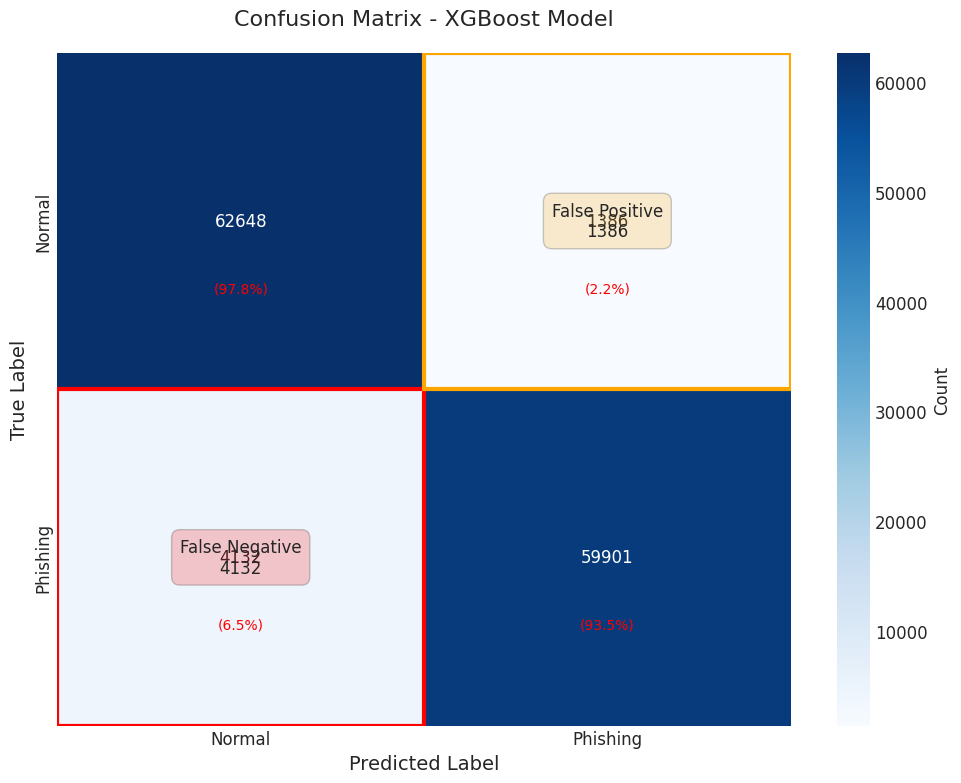


2️⃣ Creating Learning Curves...


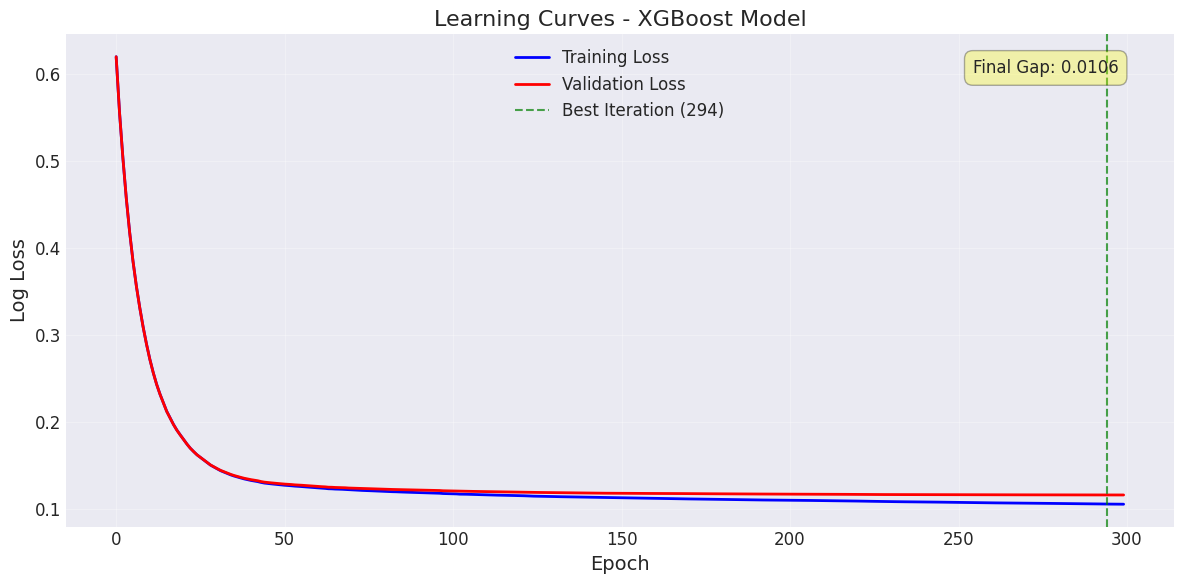


3️⃣ Analyzing Feature Importance...


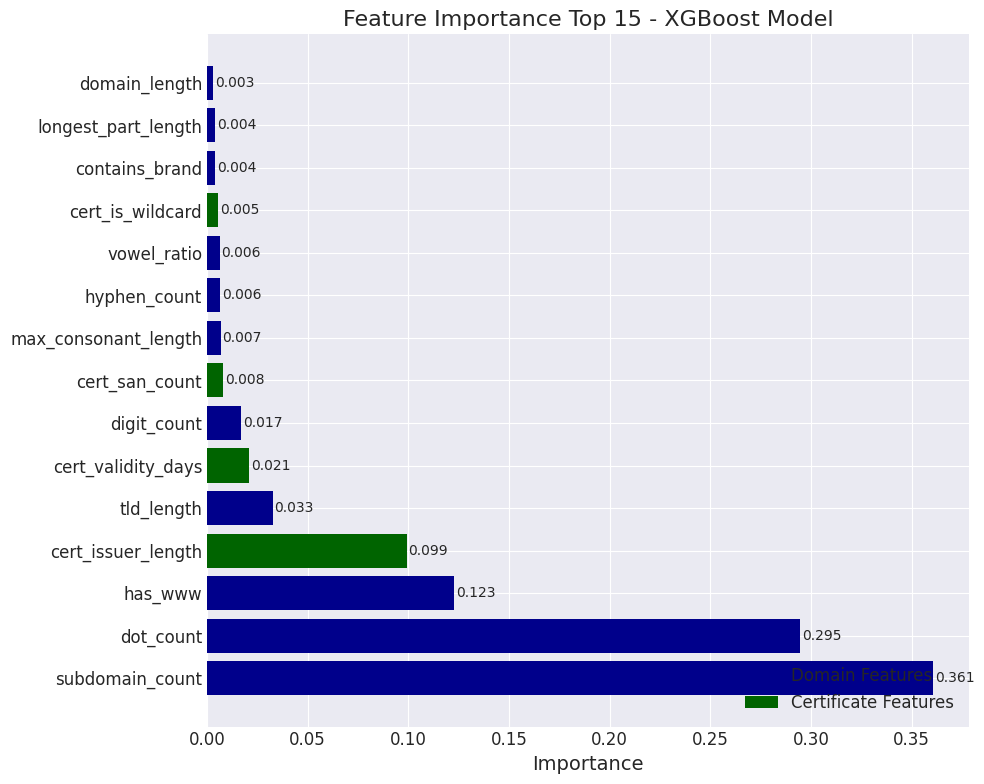


4️⃣ Analyzing Prediction Probability Distribution...


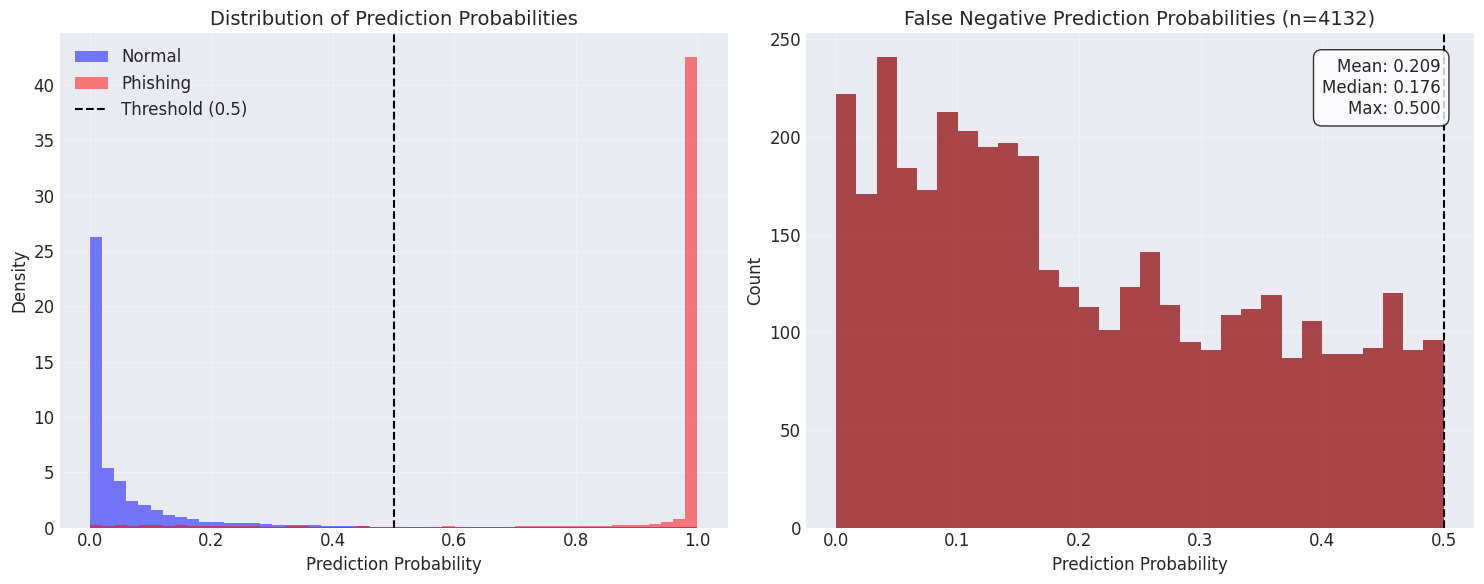


📊 Feature Importance Summary:
             feature  importance
     subdomain_count    0.360598
           dot_count    0.294721
             has_www    0.122673
  cert_issuer_length    0.099136
          tld_length    0.032581
  cert_validity_days    0.020845
         digit_count    0.016709
      cert_san_count    0.007781
max_consonant_length    0.006749
        hyphen_count    0.006358

📈 Model Evaluation Summary:
  - Most Important Feature: subdomain_count (0.361)
  - Total Domain Feature Importance: 0.867
  - Total Certificate Feature Importance: 0.133

✅ Model evaluation and visualization completed


In [18]:


"""
セル番号: 5
概要: モデルの詳細な評価と可視化（Confusion Matrix、学習曲線、特徴量重要度）
入力: model, X_test_scaled, y_test, y_pred, y_pred_proba
出力: 各種グラフ（confusion_matrix.png, learning_curves.png, feature_importance.png）
"""

# 可視化の設定
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 英語フォントを使用（文字化け防止）
plt.rcParams['font.family'] = 'DejaVu Sans'
# マイナス記号の文字化けを防ぐ
plt.rcParams['axes.unicode_minus'] = False

print("📊 Starting model evaluation and visualization...")
print("=" * 80)

# 1. Confusion Matrixの可視化
print("\n1️⃣ Creating Confusion Matrix...")

fig, ax = plt.subplots(figsize=(10, 8))

# Confusion Matrixの計算（正規化版も）
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの作成
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Phishing'],
            yticklabels=['Normal', 'Phishing'],
            cbar_kws={'label': 'Count'})

# 各セルにパーセンテージを追加
for i in range(2):
    for j in range(2):
        percentage = cm_normalized[i, j] * 100
        text = ax.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                      ha='center', va='center', fontsize=10, color='red')

plt.title('Confusion Matrix - XGBoost Model', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)

# 偽陰性と偽陽性を強調
ax.add_patch(plt.Rectangle((0, 1), 1, 1, fill=False, edgecolor='red', lw=3))
ax.add_patch(plt.Rectangle((1, 0), 1, 1, fill=False, edgecolor='orange', lw=3))

# 注釈を追加
plt.text(0.5, 1.5, f'False Negative\n{cm[1, 0]}', ha='center', va='center', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='red', alpha=0.2))
plt.text(1.5, 0.5, f'False Positive\n{cm[0, 1]}', ha='center', va='center',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='orange', alpha=0.2))

plt.tight_layout()
plt.savefig(f"{base_dirs['results']}/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. 学習曲線の可視化
print("\n2️⃣ Creating Learning Curves...")

# 訓練履歴の取得
results = model.evals_result()

fig, ax = plt.subplots(figsize=(12, 6))

epochs = range(len(results['validation_0']['logloss']))
train_loss = results['validation_0']['logloss']
val_loss = results['validation_1']['logloss']

plt.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)

# 最良の地点をマーク
best_epoch = model.best_iteration
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, 
            label=f'Best Iteration ({best_epoch})')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
plt.title('Learning Curves - XGBoost Model', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# 過学習の兆候をチェック
final_gap = val_loss[-1] - train_loss[-1]
plt.text(0.95, 0.95, f'Final Gap: {final_gap:.4f}',
         transform=ax.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig(f"{base_dirs['results']}/learning_curves.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. 特徴量重要度の可視化
print("\n3️⃣ Analyzing Feature Importance...")

# 特徴量重要度の取得
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': FEATURE_ORDER,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# 上位15特徴量を表示
fig, ax = plt.subplots(figsize=(10, 8))

top_features = importance_df.head(15)
colors = ['darkgreen' if 'cert_' in feat else 'darkblue' for feat in top_features['feature']]

bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance', fontsize=14)
plt.title('Feature Importance Top 15 - XGBoost Model', fontsize=16)

# 値を表示
for i, (idx, row) in enumerate(top_features.iterrows()):
    plt.text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}',
             va='center', fontsize=10)

# 凡例
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='darkblue', label='Domain Features'),
    Patch(facecolor='darkgreen', label='Certificate Features')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(f"{base_dirs['results']}/feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. 予測確率の分布
print("\n4️⃣ Analyzing Prediction Probability Distribution...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 全体の分布
ax1.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='Normal', color='blue', density=True)
ax1.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Phishing', color='red', density=True)
ax1.axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
ax1.set_xlabel('Prediction Probability', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Distribution of Prediction Probabilities', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 偽陰性の分布に注目
fn_mask = (y_test == 1) & (y_pred == 0)
fn_probs = y_pred_proba[fn_mask]

ax2.hist(fn_probs, bins=30, color='darkred', alpha=0.7)
ax2.axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
ax2.set_xlabel('Prediction Probability', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title(f'False Negative Prediction Probabilities (n={len(fn_probs)})', fontsize=14)
ax2.grid(True, alpha=0.3)

# 統計情報を追加
stats_text = f'Mean: {fn_probs.mean():.3f}\nMedian: {np.median(fn_probs):.3f}\nMax: {fn_probs.max():.3f}'
ax2.text(0.95, 0.95, stats_text, transform=ax2.transAxes,
         ha='right', va='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(f"{base_dirs['results']}/prediction_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# 重要度の統計サマリー
print("\n📊 Feature Importance Summary:")
print(importance_df.head(10).to_string(index=False))

print(f"\n📈 Model Evaluation Summary:")
print(f"  - Most Important Feature: {importance_df.iloc[0]['feature']} ({importance_df.iloc[0]['importance']:.3f})")
print(f"  - Total Domain Feature Importance: {importance_df[~importance_df['feature'].str.contains('cert_')]['importance'].sum():.3f}")
print(f"  - Total Certificate Feature Importance: {importance_df[importance_df['feature'].str.contains('cert_')]['importance'].sum():.3f}")

print("\n✅ Model evaluation and visualization completed")
print("=" * 80)

🔍 Starting overfitting validation and false negative analysis...

1️⃣ Creating Learning Curves with Different Data Sizes...
  ⚠️ This process may take several minutes...


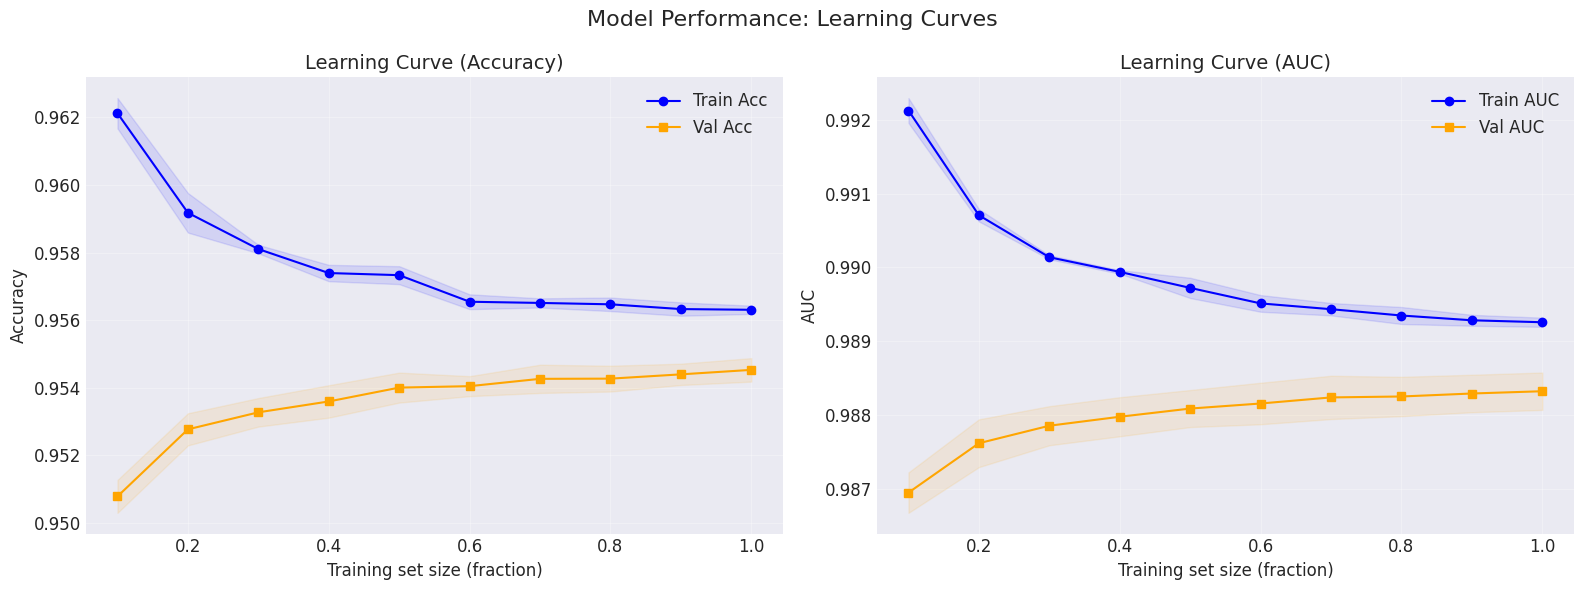


📊 Overfitting Diagnosis:
  - Accuracy Gap (Val-Train): -0.0018
  - AUC Gap (Val-Train): -0.0009
  → ✅ No signs of overfitting detected

2️⃣ Running 5-fold Cross-Validation...
  - CV AUC scores: [0.98876403 0.98930845 0.98895946 0.9891998  0.98849783]
  - Mean CV AUC: 0.9889 (±0.0003)

3️⃣ Computing Permutation Importance...


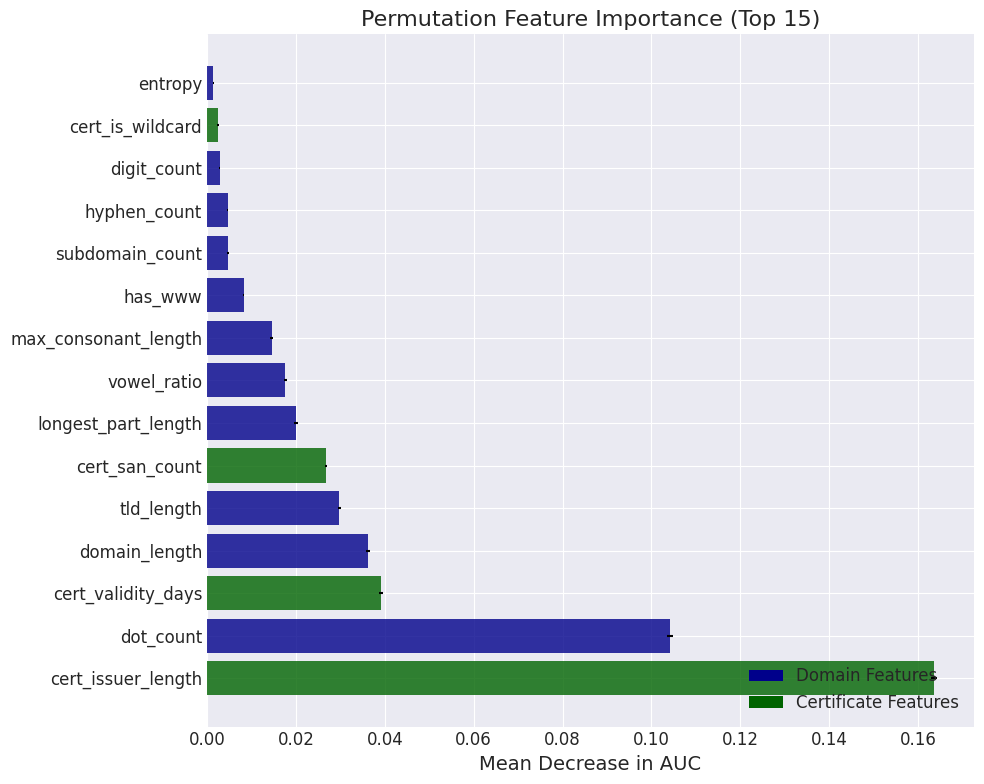


4️⃣ Detailed Analysis of False Negative Samples...

📊 False Negative Samples: 4132
  - False Negative Rate: 6.45%

⚠️ High Confidence False Negatives: 2931
  (Phishing sites that the model strongly classified as 'normal')

📊 False Negative Analysis by Source:
  - certificates: 1112/38041 (2.92%)
  - jpcert: 1980/22521 (8.79%)
  - phishtank: 1040/3471 (29.96%)

📊 False Negative Domain Characteristics:
  - Average Domain Length: 14.7
  - Min/Max Length: 4/47

  Top 10 TLDs in False Negatives:
    - .com: 2415
    - .cn: 319
    - .top: 191
    - .net: 96
    - .jp: 92
    - .xyz: 74
    - .icu: 70
    - .cc: 50
    - .org: 47
    - .co: 46

💾 False negative data saved to: results/2025-10-22_082121/false_negatives.pkl

🔍 False Negative Samples (sorted by lowest prediction probability):
                       domain  prediction_proba       source
                imtookken.com          0.000539 certificates
                   madfly.com          0.000673       jpcert
                salema

In [19]:


"""
セル番号: 6
概要: 過学習検証（データサイズ別学習曲線）と偽陰性サンプルの詳細分析
入力: X_train_scaled, X_test_scaled, y_train, y_test, domain_test
出力: overfitting_analysis.png, false_negatives.pkl
"""

from sklearn.model_selection import learning_curve
import gc

print("🔍 Starting overfitting validation and false negative analysis...")
print("=" * 80)

# 必要な変数の確認
if 'y_pred' not in globals() or 'y_pred_proba' not in globals():
    print("⚠️ Prediction results not found. Please run Cell 4 first.")
    print("  Re-running predictions...")
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# 1. データサイズを変えた学習曲線
print("\n1️⃣ Creating Learning Curves with Different Data Sizes...")
print("  ⚠️ This process may take several minutes...")

# 訓練サイズの設定
train_sizes = np.linspace(0.1, 1.0, 10)

# 学習曲線の計算（Accuracy）
train_sizes_abs, train_scores_acc, val_scores_acc = learning_curve(
    xgb.XGBClassifier(
        n_estimators=100,  # 計算時間短縮のため削減
        max_depth=8,
        learning_rate=0.1,
        random_state=42,
        device='cuda' if gpu_available else 'cpu'
    ),
    X_train_scaled, y_train,
    cv=5,
    train_sizes=train_sizes,
    scoring='accuracy',
    n_jobs=1,  # GPU使用時はn_jobs=1に設定
    return_times=False
)

# 学習曲線の計算（AUC）
_, train_scores_auc, val_scores_auc = learning_curve(
    xgb.XGBClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        random_state=42,
        device='cuda' if gpu_available else 'cpu'
    ),
    X_train_scaled, y_train,
    cv=5,
    train_sizes=train_sizes,
    scoring='roc_auc',
    n_jobs=1,  # GPU使用時はn_jobs=1に設定
    return_times=False
)

# メモリ解放
gc.collect()

# 結果の可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy曲線
train_mean_acc = train_scores_acc.mean(axis=1)
train_std_acc = train_scores_acc.std(axis=1)
val_mean_acc = val_scores_acc.mean(axis=1)
val_std_acc = val_scores_acc.std(axis=1)

ax1.plot(train_sizes, train_mean_acc, 'o-', color='blue', label='Train Acc')
ax1.plot(train_sizes, val_mean_acc, 's-', color='orange', label='Val Acc')
ax1.fill_between(train_sizes, train_mean_acc - train_std_acc,
                 train_mean_acc + train_std_acc, alpha=0.1, color='blue')
ax1.fill_between(train_sizes, val_mean_acc - val_std_acc,
                 val_mean_acc + val_std_acc, alpha=0.1, color='orange')

ax1.set_xlabel('Training set size (fraction)', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Learning Curve (Accuracy)', fontsize=14)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# AUC曲線
train_mean_auc = train_scores_auc.mean(axis=1)
train_std_auc = train_scores_auc.std(axis=1)
val_mean_auc = val_scores_auc.mean(axis=1)
val_std_auc = val_scores_auc.std(axis=1)

ax2.plot(train_sizes, train_mean_auc, 'o-', color='blue', label='Train AUC')
ax2.plot(train_sizes, val_mean_auc, 's-', color='orange', label='Val AUC')
ax2.fill_between(train_sizes, train_mean_auc - train_std_auc,
                 train_mean_auc + train_std_auc, alpha=0.1, color='blue')
ax2.fill_between(train_sizes, val_mean_auc - val_std_auc,
                 val_mean_auc + val_std_auc, alpha=0.1, color='orange')

ax2.set_xlabel('Training set size (fraction)', fontsize=12)
ax2.set_ylabel('AUC', fontsize=12)
ax2.set_title('Learning Curve (AUC)', fontsize=14)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.suptitle('Model Performance: Learning Curves', fontsize=16)
plt.tight_layout()
plt.savefig(f"{base_dirs['results']}/learning_curves_by_size.png", dpi=300, bbox_inches='tight')
plt.show()

# 過学習の診断
final_gap_acc = val_mean_acc[-1] - train_mean_acc[-1]
final_gap_auc = val_mean_auc[-1] - train_mean_auc[-1]

print(f"\n📊 Overfitting Diagnosis:")
print(f"  - Accuracy Gap (Val-Train): {final_gap_acc:.4f}")
print(f"  - AUC Gap (Val-Train): {final_gap_auc:.4f}")

if abs(final_gap_acc) < 0.01 and abs(final_gap_auc) < 0.01:
    print("  → ✅ No signs of overfitting detected")
elif abs(final_gap_acc) < 0.02 and abs(final_gap_auc) < 0.02:
    print("  → ⚠️ Mild overfitting may be present")
else:
    print("  → ❌ Overfitting is likely occurring")

# 2. 5-fold交差検証
print("\n2️⃣ Running 5-fold Cross-Validation...")

# 交差検証用のモデル（early_stoppingなし）
cv_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    objective='binary:logistic',
    eval_metric='logloss',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    device='cuda' if gpu_available else 'cpu'
)

cv_scores = cross_val_score(
    cv_model, X_train_scaled, y_train, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=1  # GPU使用時はn_jobs=1に設定
)

print(f"  - CV AUC scores: {cv_scores}")
print(f"  - Mean CV AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# 3. Permutation Importance（テストデータで実施）
print("\n3️⃣ Computing Permutation Importance...")

perm_importance = permutation_importance(
    model, X_test_scaled, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=1  # GPU使用時はn_jobs=1に設定
)

# Permutation Importanceの可視化
perm_imp_df = pd.DataFrame({
    'feature': FEATURE_ORDER,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))

top_perm_features = perm_imp_df.head(15)
colors = ['darkgreen' if 'cert_' in feat else 'darkblue' for feat in top_perm_features['feature']]

bars = ax.barh(range(len(top_perm_features)), 
                top_perm_features['importance_mean'],
                xerr=top_perm_features['importance_std'],
                color=colors, alpha=0.8)

ax.set_yticks(range(len(top_perm_features)))
ax.set_yticklabels(top_perm_features['feature'])
ax.set_xlabel('Mean Decrease in AUC', fontsize=14)
ax.set_title('Permutation Feature Importance (Top 15)', fontsize=16)

# 凡例
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='darkblue', label='Domain Features'),
    Patch(facecolor='darkgreen', label='Certificate Features')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(f"{base_dirs['results']}/permutation_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. 偽陰性サンプルの詳細分析
print("\n4️⃣ Detailed Analysis of False Negative Samples...")

# 偽陰性のインデックスを取得
fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
fn_proba = y_pred_proba[fn_indices]

print(f"\n📊 False Negative Samples: {len(fn_indices)}")
print(f"  - False Negative Rate: {len(fn_indices) / sum(y_test == 1) * 100:.2f}%")

# グローバル変数から必要な変数を取得
if 'domain_test' not in globals() or 'source_test' not in globals():
    print("⚠️ Domain information not found. Loading from saved data...")
    # test_data.pklから読み込み
    try:
        test_data = joblib.load(f"{base_dirs['data']}/test_data.pkl")
        domain_test = test_data['domains']
        source_test = test_data['sources']
        print("✅ Domain information loaded successfully")
    except Exception as e:
        print(f"❌ Failed to load domain information: {e}")
        # 基本的な分析のみ実行
        false_negatives_data = {
            'indices': fn_indices,
            'features': X_test[fn_indices],
            'prediction_proba': fn_proba,
            'statistics': {
                'total_fn': len(fn_indices),
                'fn_rate': len(fn_indices) / sum(y_test == 1) * 100,
                'avg_proba': float(fn_proba.mean()),
                'min_proba': float(fn_proba.min()),
                'max_proba': float(fn_proba.max())
            }
        }
        joblib.dump(false_negatives_data, f"{base_dirs['results']}/false_negatives.pkl")
        print(f"  - Average Prediction Probability: {fn_proba.mean():.3f}")
        print(f"  - Minimum Prediction Probability: {fn_proba.min():.3f}")
        print("\n⚠️ Saved limited false negative data (no domain information)")
    
if 'domain_test' in globals() and 'source_test' in globals():
    # 偽陰性サンプルのデータフレーム作成
    fn_analysis_df = pd.DataFrame({
        'domain': domain_test[fn_indices],
        'source': source_test[fn_indices],
        'prediction_proba': fn_proba,
        'confidence': 1 - fn_proba  # 正常と判定した確信度
    })

    # 高確信度偽陰性（予測確率が0.3未満）
    high_confidence_fn = fn_analysis_df[fn_analysis_df['prediction_proba'] < 0.3].copy()
    print(f"\n⚠️ High Confidence False Negatives: {len(high_confidence_fn)}")
    print("  (Phishing sites that the model strongly classified as 'normal')")

    # ソース別の偽陰性率
    print("\n📊 False Negative Analysis by Source:")
    for source in np.unique(source_test):
        source_mask = source_test == source
        source_phishing = (y_test == 1) & source_mask
        source_fn = (y_test == 1) & (y_pred == 0) & source_mask
        
        if source_phishing.sum() > 0:
            fn_rate = source_fn.sum() / source_phishing.sum() * 100
            print(f"  - {source}: {source_fn.sum()}/{source_phishing.sum()} ({fn_rate:.2f}%)")

    # 偽陰性のドメインパターン分析
    print("\n📊 False Negative Domain Characteristics:")
    fn_domains = domain_test[fn_indices]
    fn_domain_lengths = [len(d) for d in fn_domains]
    print(f"  - Average Domain Length: {np.mean(fn_domain_lengths):.1f}")
    print(f"  - Min/Max Length: {min(fn_domain_lengths)}/{max(fn_domain_lengths)}")

    # TLDの分析
    fn_tlds = [d.split('.')[-1] if '.' in d else '' for d in fn_domains]
    tld_counts = pd.Series(fn_tlds).value_counts().head(10)
    print("\n  Top 10 TLDs in False Negatives:")
    for tld, count in tld_counts.items():
        print(f"    - .{tld}: {count}")

    # 偽陰性データの辞書を作成
    false_negatives_data = {
        'analysis_df': fn_analysis_df,
        'indices': fn_indices,
        'features': X_test[fn_indices],
        'high_confidence_fn': high_confidence_fn,
        'statistics': {
            'total_fn': int(len(fn_indices)),
            'fn_rate': float(len(fn_indices) / sum(y_test == 1) * 100),
            'high_confidence_fn_count': int(len(high_confidence_fn)),
            'avg_proba': float(fn_proba.mean()),
            'min_proba': float(fn_proba.min()),
            'max_proba': float(fn_proba.max())
        }
    }

    # 保存
    joblib.dump(false_negatives_data, f"{base_dirs['results']}/false_negatives.pkl")
    print(f"\n💾 False negative data saved to: {base_dirs['results']}/false_negatives.pkl")

    # サンプル表示
    print("\n🔍 False Negative Samples (sorted by lowest prediction probability):")
    print(fn_analysis_df.nsmallest(10, 'prediction_proba')[['domain', 'prediction_proba', 'source']].to_string(index=False))
    
    # 保存データの確認
    print("\n📋 Verifying saved data format:")
    with open(f"{base_dirs['results']}/false_negatives.pkl", 'rb') as f:
        fn_data = joblib.load(f)
    
    print(f"  - Data type: {type(fn_data)}")
    if isinstance(fn_data, dict):
        print(f"  - Keys: {list(fn_data.keys())}")
        print(f"  - analysis_df type: {type(fn_data.get('analysis_df'))}")
        print(f"  - analysis_df rows: {len(fn_data.get('analysis_df', []))}")
        print("  ✅ Data saved in correct format!")

print("\n✅ Overfitting validation and false negative analysis completed")
print("=" * 80)

In [20]:


"""
セル番号: 7
概要: プロジェクト全体のサマリーと05_ai_agent_analysis.ipynbへの引き継ぎ情報
入力: training_metrics.json, false_negatives.pkl
出力: project_summary.txt
"""

print("=" * 80)
print("📋 PROJECT SUMMARY: 02_xgboost_training_evaluation.py")
print("=" * 80)

# トレーニングメトリクスの読み込み
with open(f"{base_dirs['results']}/training_metrics.json", 'r') as f:
    metrics = json.load(f)

# セッション情報
print(f"\n📅 Session Information:")
print(f"  - Session ID: {session_id}")
print(f"  - Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"  - GPU Used: {'Yes' if gpu_available else 'No'}")

# データ統計
print(f"\n📊 Data Statistics:")
print(f"  - Total samples: {len(X_train) + len(X_test):,}")
print(f"  - Training samples: {len(X_train):,}")
print(f"  - Test samples: {len(X_test):,}")
print(f"  - Features: {len(FEATURE_ORDER)}")
print(f"  - Class balance: 50.0% / 50.0%")

# モデル性能
print(f"\n🎯 Model Performance:")
print(f"  - Accuracy: {metrics['performance']['accuracy']:.4f}")
print(f"  - Precision: {metrics['performance']['precision']:.4f}")
print(f"  - Recall: {metrics['performance']['recall']:.4f}")
print(f"  - F1-Score: {metrics['performance']['f1_score']:.4f}")
print(f"  - ROC-AUC: {metrics['performance']['roc_auc']:.4f}")

# 偽陰性分析
print(f"\n⚠️ False Negative Analysis:")
print(f"  - False Negative Rate: {metrics['performance']['false_negative_rate']:.4f}")
print(f"  - False Negatives: {metrics['confusion_matrix']['fn']:,}")
print(f"  - False Positive Rate: {metrics['performance']['false_positive_rate']:.4f}")
print(f"  - False Positives: {metrics['confusion_matrix']['fp']:,}")

# 保存ファイル
print(f"\n💾 Saved Files:")
print(f"  Models:")
print(f"    - {base_dirs['models']}/xgboost_model.pkl")
print(f"    - {base_dirs['models']}/scaler.pkl")
print(f"    - {base_dirs['models']}/feature_order.json")
print(f"  Results:")
print(f"    - {base_dirs['results']}/confusion_matrix.png")
print(f"    - {base_dirs['results']}/learning_curves.png")
print(f"    - {base_dirs['results']}/feature_importance.png")
print(f"    - {base_dirs['results']}/prediction_distribution.png")
print(f"    - {base_dirs['results']}/learning_curves_by_size.png")
print(f"    - {base_dirs['results']}/permutation_importance.png")
print(f"    - {base_dirs['results']}/false_negatives.pkl")
print(f"    - {base_dirs['results']}/training_metrics.json")
print(f"  Data:")
print(f"    - {base_dirs['data']}/train_data.pkl")
print(f"    - {base_dirs['data']}/test_data.pkl")

# 05_ai_agent_analysis.ipynbへの引き継ぎ
print(f"\n🔄 For 05_ai_agent_analysis.ipynb:")
print(f"  Key findings:")
print(f"    - {metrics['confusion_matrix']['fn']:,} false negatives need AI agent analysis")
print(f"    - False negative rate: {metrics['performance']['false_negative_rate']*100:.2f}%")
print(f"    - These are phishing sites that XGBoost missed")
print(f"\n  Load the following files:")
print(f"    - Model: models/{session_id}/xgboost_model.pkl")
print(f"    - False negatives: results/{session_id}/false_negatives.pkl")
print(f"    - Scaler: models/{session_id}/scaler.pkl")

# サマリーファイルの保存
summary_text = f"""
PROJECT SUMMARY: 02_xgboost_training_evaluation
===============================================

Session ID: {session_id}
Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATA STATISTICS:
- Total samples: {len(X_train) + len(X_test):,}
- Training samples: {len(X_train):,}
- Test samples: {len(X_test):,}
- Features: {len(FEATURE_ORDER)}

MODEL PERFORMANCE:
- Accuracy: {metrics['performance']['accuracy']:.4f}
- Precision: {metrics['performance']['precision']:.4f}
- Recall: {metrics['performance']['recall']:.4f}
- F1-Score: {metrics['performance']['f1_score']:.4f}
- ROC-AUC: {metrics['performance']['roc_auc']:.4f}

FALSE NEGATIVE ANALYSIS:
- False Negative Rate: {metrics['performance']['false_negative_rate']:.4f}
- False Negatives: {metrics['confusion_matrix']['fn']:,}
- False Positive Rate: {metrics['performance']['false_positive_rate']:.4f}
- False Positives: {metrics['confusion_matrix']['fp']:,}

CONCLUSION:
The XGBoost model achieved high overall performance with {metrics['performance']['accuracy']:.1%} accuracy.
However, {metrics['confusion_matrix']['fn']:,} phishing sites were misclassified as normal.
These false negatives will be analyzed by the AI agent in 05_ai_agent_analysis.ipynb.

NEXT STEPS:
1. Run 05_ai_agent_analysis.ipynb to analyze false negatives with GPT-4o mini
2. Identify patterns that ML model missed
3. Develop hybrid ML+LLM approach for improved detection
"""

with open(f"{base_dirs['results']}/project_summary.txt", 'w') as f:
    f.write(summary_text)

print(f"\n✅ Project summary saved to: {base_dirs['results']}/project_summary.txt")

# 重要な洞察
if 'importance_df' in globals():
    print(f"\n🔍 Key Insights:")
    print(f"  Most important features:")
    for i, (idx, row) in enumerate(importance_df.head(5).iterrows()):
        print(f"    {i+1}. {row['feature']}: {row['importance']:.3f}")

print("\n" + "=" * 80)
print("✨ 02_xgboost_training_evaluation.py COMPLETED SUCCESSFULLY!")
print("🚀 Next: Run 05_ai_agent_analysis.ipynb to analyze false negatives with AI")
print("=" * 80)

📋 PROJECT SUMMARY: 02_xgboost_training_evaluation.py

📅 Session Information:
  - Session ID: 2025-10-22_082121
  - Date: 2025-10-22 08:32:02
  - GPU Used: Yes

📊 Data Statistics:
  - Total samples: 640,332
  - Training samples: 512,265
  - Test samples: 128,067
  - Features: 20
  - Class balance: 50.0% / 50.0%

🎯 Model Performance:
  - Accuracy: 0.9569
  - Precision: 0.9774
  - Recall: 0.9355
  - F1-Score: 0.9560
  - ROC-AUC: 0.9890

⚠️ False Negative Analysis:
  - False Negative Rate: 0.0645
  - False Negatives: 4,132
  - False Positive Rate: 0.0216
  - False Positives: 1,386

💾 Saved Files:
  Models:
    - models/2025-10-22_082121/xgboost_model.pkl
    - models/2025-10-22_082121/scaler.pkl
    - models/2025-10-22_082121/feature_order.json
  Results:
    - results/2025-10-22_082121/confusion_matrix.png
    - results/2025-10-22_082121/learning_curves.png
    - results/2025-10-22_082121/feature_importance.png
    - results/2025-10-22_082121/prediction_distribution.png
    - results/2025

🔬 偽陰性（False Negative）の予測確率分布詳細分析
✅ 偽陰性データを読み込みました

📊 1. 偽陰性の基本統計
----------------------------------------
  - 総フィッシングサンプル数: 64,033
  - 偽陰性（FN）数: 4,132
  - 偽陰性率: 6.45%

  予測確率の統計:
    - 平均値: 0.2086
    - 中央値: 0.1762
    - 標準偏差: 0.1436
    - 最小値: 0.0005
    - 最大値: 0.4998

📊 2. 予測確率の区間別分布
----------------------------------------

予測確率区間別の偽陰性分布:
       区間  FN数   FN割合(%)  累積FN数    累積割合(%)
0.00-0.05  630 15.246854    630  15.246854
0.05-0.10  565 13.673766   1195  28.920620
0.10-0.15  603 14.593417   1798  43.514037
0.15-0.20  443 10.721200   2241  54.235237
0.20-0.25  340  8.228461   2581  62.463698
0.25-0.30  350  8.470474   2931  70.934172
0.30-0.35  312  7.550823   3243  78.484995
0.35-0.40  313  7.575024   3556  86.060019
0.40-0.45  269  6.510165   3825  92.570184
0.45-0.50  307  7.429816   4132 100.000000
0.50-0.55    0  0.000000   4132 100.000000
0.55-0.60    0  0.000000   4132 100.000000
0.60-0.65    0  0.000000   4132 100.000000
0.65-0.70    0  0.000000   4132 100.000000
0.70-0.75  

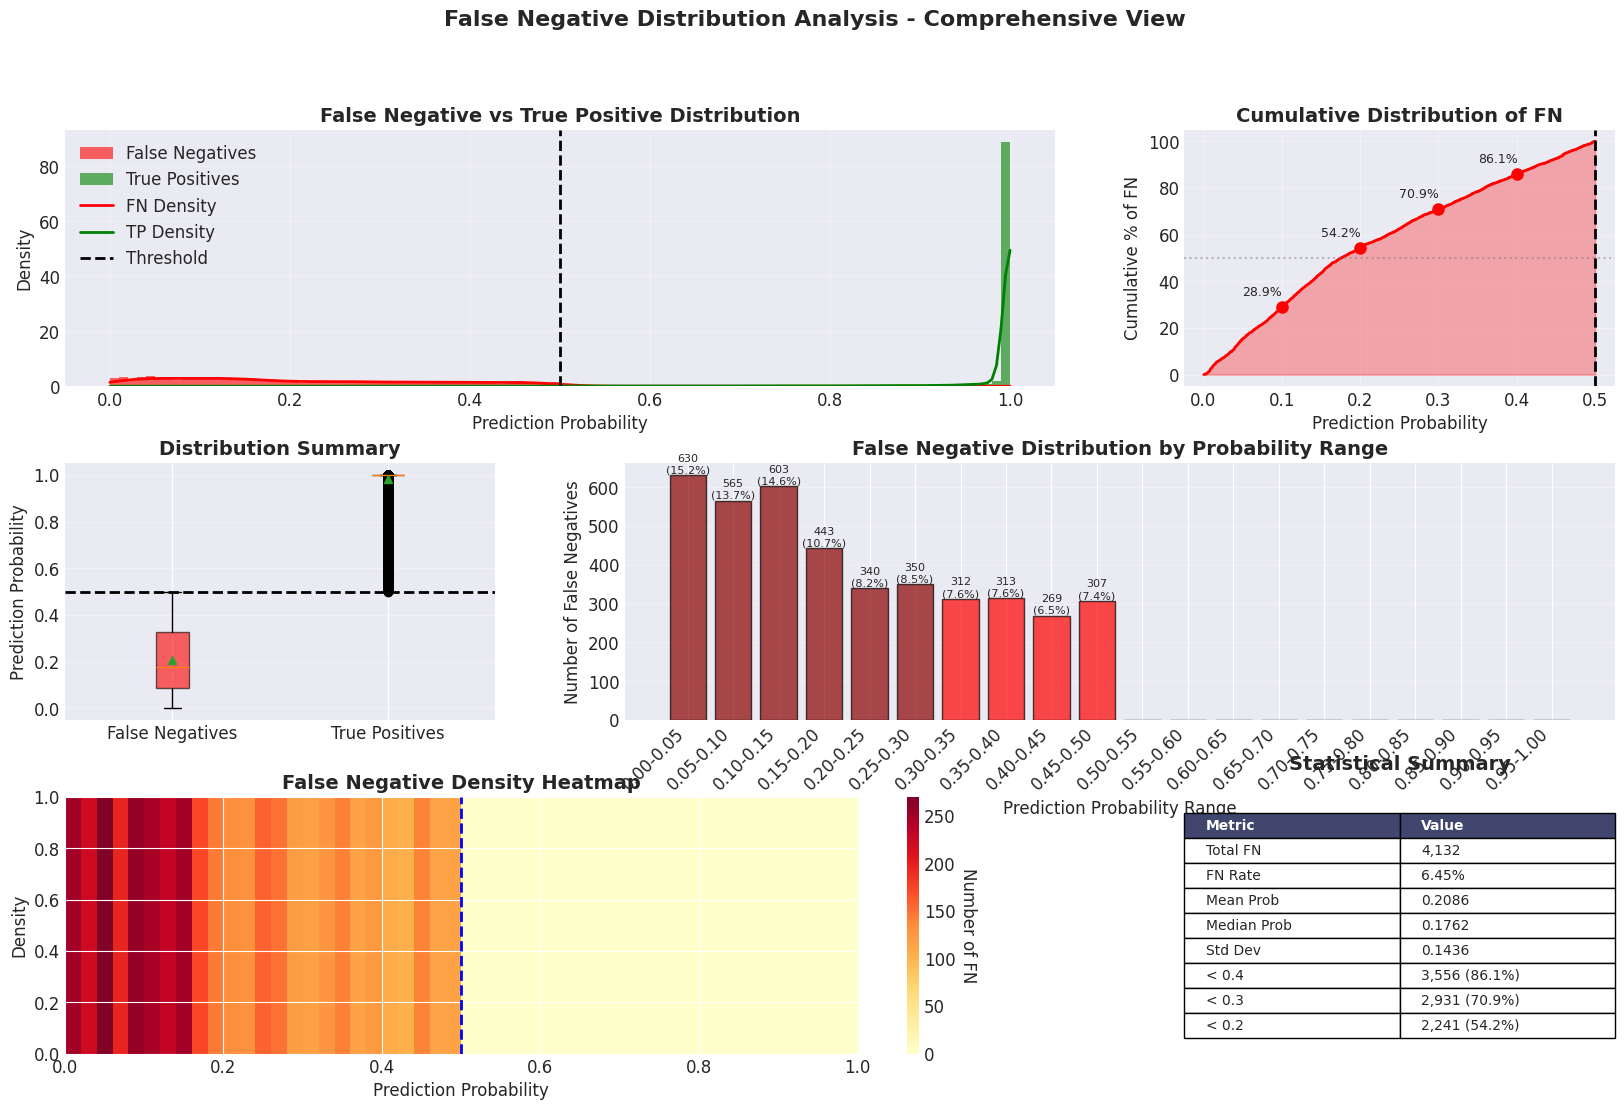


💾 5. 統計情報を保存中...
  ✅ 統計情報を保存: results/2025-10-22_082121/fn_distribution_stats.json

💡 重要な知見

1. 閾値付近（0.40-0.50）の偽陰性: 13.9%
   → 偽陰性は閾値から離れた領域に広く分布しています

2. 予測確率0.3未満の偽陰性: 70.9%
   → MLモデルが高い確信度で「正常」と誤判定したケースが多数存在
   → これらのケースにAIエージェントが特に有効と考えられます

3. 分布の歪度（Skewness）: 0.407
   → 分布は比較的対称的です

4. AIエージェント適用範囲の推奨:
   → 予測確率 0.1-0.7 の範囲でAIエージェントを適用することを推奨
   → 特に0.3未満の低確率領域での効果が期待できます

✅ 偽陰性分布の詳細分析が完了しました


In [21]:


"""
プログラム名: 02_xgboost_training_evaluation.ipynb
概要: MLモデルが見逃したフィッシングサイトをAIエージェント（GPT-4o mini）で検出
目的: 国際学会論文での発表（MLとLLMのハイブリッドアプローチの実証）
作成日: 2024-01-22
"""

"""
セル番号: 7.5
概要: 偽陰性の予測確率分布の詳細分析（閾値付近 vs 全体）
入力: y_test, y_pred, y_pred_proba, false_negatives.pkl
出力: fn_distribution_analysis.png, fn_distribution_stats.json
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
import joblib
from datetime import datetime
from typing import Dict, List, Tuple

print("=" * 80)
print("🔬 偽陰性（False Negative）の予測確率分布詳細分析")
print("=" * 80)

# 必要な変数の確認
required_vars = ['y_test', 'y_pred', 'y_pred_proba', 'base_dirs']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"⚠️ 必要な変数が不足しています: {missing_vars}")
    print("   Cell 4（モデル訓練）を先に実行してください")
    raise NameError(f"Required variables not found: {missing_vars}")

# 偽陰性データの読み込み
try:
    with open(f"{base_dirs['results']}/false_negatives.pkl", 'rb') as f:
        fn_data = joblib.load(f)
    print(f"✅ 偽陰性データを読み込みました")
except FileNotFoundError:
    print("⚠️ false_negatives.pklが見つかりません。Cell 6を先に実行してください")
    raise

# ========================================
# 1. 基本的な偽陰性の分布統計
# ========================================

print("\n📊 1. 偽陰性の基本統計")
print("-" * 40)

# 偽陰性のマスクと予測確率を取得
fn_mask = (y_test == 1) & (y_pred == 0)
fn_proba = y_pred_proba[fn_mask]
tp_mask = (y_test == 1) & (y_pred == 1)
tp_proba = y_pred_proba[tp_mask]

total_phishing = sum(y_test == 1)
total_fn = len(fn_proba)
fn_rate = total_fn / total_phishing * 100

print(f"  - 総フィッシングサンプル数: {total_phishing:,}")
print(f"  - 偽陰性（FN）数: {total_fn:,}")
print(f"  - 偽陰性率: {fn_rate:.2f}%")
print(f"\n  予測確率の統計:")
print(f"    - 平均値: {fn_proba.mean():.4f}")
print(f"    - 中央値: {np.median(fn_proba):.4f}")
print(f"    - 標準偏差: {fn_proba.std():.4f}")
print(f"    - 最小値: {fn_proba.min():.4f}")
print(f"    - 最大値: {fn_proba.max():.4f}")

# ========================================
# 2. 予測確率の区間別分析
# ========================================

print("\n📊 2. 予測確率の区間別分布")
print("-" * 40)

# 区間を定義（0.05刻みの細かい分析）
bins = np.arange(0, 1.05, 0.05)
bin_labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]

# 偽陰性の区間別カウント
fn_hist, _ = np.histogram(fn_proba, bins=bins)
fn_cumsum = np.cumsum(fn_hist)
fn_cumsum_pct = fn_cumsum / total_fn * 100

# 詳細な統計テーブルを作成
distribution_df = pd.DataFrame({
    '区間': bin_labels,
    'FN数': fn_hist,
    'FN割合(%)': fn_hist / total_fn * 100,
    '累積FN数': fn_cumsum,
    '累積割合(%)': fn_cumsum_pct
})

print("\n予測確率区間別の偽陰性分布:")
print(distribution_df.to_string(index=False))

# DataFrameをJSON用に変換（NumPy型をPython型に変換）
distribution_dict = []
for _, row in distribution_df.iterrows():
    distribution_dict.append({
        '区間': str(row['区間']),
        'FN数': int(row['FN数']),
        'FN割合(%)': float(row['FN割合(%)']),
        '累積FN数': int(row['累積FN数']),
        '累積割合(%)': float(row['累積割合(%)'])
    })

# ========================================
# 3. 閾値からの距離別分析
# ========================================

print("\n📊 3. 閾値（0.5）からの距離別分析")
print("-" * 40)

threshold = 0.5
distance_ranges = {
    '閾値直前（0.45-0.50）': (0.45, 0.50),
    '閾値付近（0.40-0.45）': (0.40, 0.45),
    '中距離（0.30-0.40）': (0.30, 0.40),
    '遠距離（0.20-0.30）': (0.20, 0.30),
    '超遠距離（0.00-0.20）': (0.00, 0.20)
}

distance_stats = {}
for range_name, (low, high) in distance_ranges.items():
    range_mask = (fn_proba >= low) & (fn_proba < high)
    range_count = range_mask.sum()
    range_pct = range_count / total_fn * 100 if total_fn > 0 else 0
    distance_stats[range_name] = {
        'count': int(range_count),
        'percentage': float(range_pct)
    }
    print(f"  {range_name}: {range_count:,}件 ({range_pct:.1f}%)")

# 重要な累積統計
print("\n📊 累積統計（閾値から離れた偽陰性）:")
cumulative_ranges = [
    (0.4, "予測確率 < 0.4"),
    (0.3, "予測確率 < 0.3"),
    (0.2, "予測確率 < 0.2"),
    (0.1, "予測確率 < 0.1")
]

for threshold_val, description in cumulative_ranges:
    count = (fn_proba < threshold_val).sum()
    pct = count / total_fn * 100 if total_fn > 0 else 0
    print(f"  {description}: {count:,}件 ({pct:.1f}%)")

# ========================================
# 4. 可視化
# ========================================

print("\n📊 4. 分布の可視化を作成中...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 4.1. ヒストグラムと密度プロット
ax1 = fig.add_subplot(gs[0, :2])
ax1.hist(fn_proba, bins=50, alpha=0.6, color='red', label='False Negatives', density=True)
ax1.hist(tp_proba, bins=50, alpha=0.6, color='green', label='True Positives', density=True)

# カーネル密度推定
if len(fn_proba) > 1:
    density_fn = stats.gaussian_kde(fn_proba)
    x_range = np.linspace(0, 1, 200)
    ax1.plot(x_range, density_fn(x_range), 'r-', linewidth=2, label='FN Density')

if len(tp_proba) > 1:
    density_tp = stats.gaussian_kde(tp_proba)
    ax1.plot(x_range, density_tp(x_range), 'g-', linewidth=2, label='TP Density')

ax1.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
ax1.set_xlabel('Prediction Probability', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('False Negative vs True Positive Distribution', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 4.2. 累積分布関数（CDF）
ax2 = fig.add_subplot(gs[0, 2])
sorted_fn_proba = np.sort(fn_proba)
cumulative_pct = np.arange(1, len(sorted_fn_proba) + 1) / len(sorted_fn_proba) * 100

ax2.plot(sorted_fn_proba, cumulative_pct, 'r-', linewidth=2)
ax2.fill_between(sorted_fn_proba, 0, cumulative_pct, alpha=0.3, color='red')
ax2.axvline(x=0.5, color='black', linestyle='--', linewidth=2)
ax2.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Prediction Probability', fontsize=12)
ax2.set_ylabel('Cumulative % of FN', fontsize=12)
ax2.set_title('Cumulative Distribution of FN', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 重要な点をマーク
for prob_threshold in [0.1, 0.2, 0.3, 0.4]:
    pct = (fn_proba < prob_threshold).sum() / len(fn_proba) * 100
    ax2.plot(prob_threshold, pct, 'ro', markersize=8)
    ax2.annotate(f'{pct:.1f}%', xy=(prob_threshold, pct), 
                xytext=(prob_threshold-0.05, pct+5),
                fontsize=9)

# 4.3. 箱ひげ図と分布の要約
ax3 = fig.add_subplot(gs[1, 0])
box_data = [fn_proba, tp_proba]
bp = ax3.boxplot(box_data, labels=['False Negatives', 'True Positives'],
                  patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('red')
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor('green')
bp['boxes'][1].set_alpha(0.6)

ax3.axhline(y=0.5, color='black', linestyle='--', linewidth=2)
ax3.set_ylabel('Prediction Probability', fontsize=12)
ax3.set_title('Distribution Summary', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4.4. 区間別偽陰性数の棒グラフ
ax4 = fig.add_subplot(gs[1, 1:])
colors = ['darkred' if float(label.split('-')[0]) < 0.3 else 
          'red' if float(label.split('-')[0]) < 0.5 else 
          'orange' for label in bin_labels]

bars = ax4.bar(range(len(bin_labels)), fn_hist, color=colors, alpha=0.7, edgecolor='black')
ax4.set_xticks(range(len(bin_labels)))
ax4.set_xticklabels(bin_labels, rotation=45, ha='right')
ax4.set_xlabel('Prediction Probability Range', fontsize=12)
ax4.set_ylabel('Number of False Negatives', fontsize=12)
ax4.set_title('False Negative Distribution by Probability Range', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 各棒の上に値を表示
for i, (bar, value) in enumerate(zip(bars, fn_hist)):
    if value > 0:
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value}\n({value/total_fn*100:.1f}%)', 
                ha='center', va='bottom', fontsize=8)

# 4.5. ヒートマップ（2D密度）
ax5 = fig.add_subplot(gs[2, :2])
# 予測確率を細かいビンに分割してヒートマップを作成
prob_bins = np.linspace(0, 1, 51)
hist_2d = np.histogram(fn_proba, bins=prob_bins)[0]

# ヒートマップデータの作成（1行のデータを複数行に複製して見やすくする）
heatmap_data = np.repeat(hist_2d.reshape(1, -1), 10, axis=0)

im = ax5.imshow(heatmap_data, aspect='auto', cmap='YlOrRd', 
                extent=[0, 1, 0, 1], origin='lower')
ax5.axvline(x=0.5, color='blue', linestyle='--', linewidth=2)
ax5.set_xlabel('Prediction Probability', fontsize=12)
ax5.set_ylabel('Density', fontsize=12)
ax5.set_title('False Negative Density Heatmap', fontsize=14, fontweight='bold')

# カラーバーを追加
cbar = plt.colorbar(im, ax=ax5)
cbar.set_label('Number of FN', rotation=270, labelpad=15)

# 4.6. 統計サマリーテーブル
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('tight')
ax6.axis('off')

# サマリーテーブルのデータ
summary_data = [
    ['Metric', 'Value'],
    ['Total FN', f'{total_fn:,}'],
    ['FN Rate', f'{fn_rate:.2f}%'],
    ['Mean Prob', f'{fn_proba.mean():.4f}'],
    ['Median Prob', f'{np.median(fn_proba):.4f}'],
    ['Std Dev', f'{fn_proba.std():.4f}'],
    ['< 0.4', f'{(fn_proba < 0.4).sum():,} ({(fn_proba < 0.4).sum()/total_fn*100:.1f}%)'],
    ['< 0.3', f'{(fn_proba < 0.3).sum():,} ({(fn_proba < 0.3).sum()/total_fn*100:.1f}%)'],
    ['< 0.2', f'{(fn_proba < 0.2).sum():,} ({(fn_proba < 0.2).sum()/total_fn*100:.1f}%)'],
]

table = ax6.table(cellText=summary_data, loc='center', cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# ヘッダー行のスタイリング
for i in range(2):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax6.set_title('Statistical Summary', fontsize=14, fontweight='bold', pad=20)

# 全体のタイトル
fig.suptitle('False Negative Distribution Analysis - Comprehensive View', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig(f"{base_dirs['results']}/fn_distribution_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# 5. 統計情報の保存
# ========================================

print("\n💾 5. 統計情報を保存中...")

# 分析結果をJSON形式で保存
fn_stats = {
    'analysis_date': datetime.now().isoformat(),
    'basic_statistics': {
        'total_phishing_samples': int(total_phishing),
        'total_false_negatives': int(total_fn),
        'false_negative_rate': float(fn_rate),
        'mean_probability': float(fn_proba.mean()),
        'median_probability': float(np.median(fn_proba)),
        'std_probability': float(fn_proba.std()),
        'min_probability': float(fn_proba.min()),
        'max_probability': float(fn_proba.max())
    },
    'distribution_by_range': distribution_dict,  # 変換済みのdictを使用
    'distance_from_threshold': {k: v for k, v in distance_stats.items()},
    'cumulative_statistics': {
        'below_0.4': {
            'count': int((fn_proba < 0.4).sum()),
            'percentage': float((fn_proba < 0.4).sum() / total_fn * 100)
        },
        'below_0.3': {
            'count': int((fn_proba < 0.3).sum()),
            'percentage': float((fn_proba < 0.3).sum() / total_fn * 100)
        },
        'below_0.2': {
            'count': int((fn_proba < 0.2).sum()),
            'percentage': float((fn_proba < 0.2).sum() / total_fn * 100)
        },
        'below_0.1': {
            'count': int((fn_proba < 0.1).sum()),
            'percentage': float((fn_proba < 0.1).sum() / total_fn * 100)
        }
    },
    'quartiles': {
        'q1': float(np.percentile(fn_proba, 25)),
        'q2_median': float(np.percentile(fn_proba, 50)),
        'q3': float(np.percentile(fn_proba, 75)),
        'iqr': float(np.percentile(fn_proba, 75) - np.percentile(fn_proba, 25))
    }
}

# JSONファイルとして保存
with open(f"{base_dirs['results']}/fn_distribution_stats.json", 'w') as f:
    json.dump(fn_stats, f, indent=2, ensure_ascii=False)

print(f"  ✅ 統計情報を保存: {base_dirs['results']}/fn_distribution_stats.json")

# ========================================
# 6. 重要な知見のまとめ
# ========================================

print("\n" + "=" * 80)
print("💡 重要な知見")
print("=" * 80)

# 閾値付近の集中度を評価
near_threshold_pct = distance_stats['閾値直前（0.45-0.50）']['percentage'] + \
                     distance_stats['閾値付近（0.40-0.45）']['percentage']

print(f"\n1. 閾値付近（0.40-0.50）の偽陰性: {near_threshold_pct:.1f}%")
if near_threshold_pct > 50:
    print("   → 偽陰性の多くが閾値付近に集中しています")
elif near_threshold_pct > 30:
    print("   → 偽陰性は閾値付近にある程度集中していますが、広く分布もしています")
else:
    print("   → 偽陰性は閾値から離れた領域に広く分布しています")

# 低確率領域の偽陰性
low_prob_pct = fn_stats['cumulative_statistics']['below_0.3']['percentage']
print(f"\n2. 予測確率0.3未満の偽陰性: {low_prob_pct:.1f}%")
if low_prob_pct > 30:
    print("   → MLモデルが高い確信度で「正常」と誤判定したケースが多数存在")
    print("   → これらのケースにAIエージェントが特に有効と考えられます")

# 分布の偏り
skewness = stats.skew(fn_proba)
print(f"\n3. 分布の歪度（Skewness）: {skewness:.3f}")
if skewness > 0.5:
    print("   → 分布は左に偏っています（低確率側に多い）")
elif skewness < -0.5:
    print("   → 分布は右に偏っています（高確率側に多い）")
else:
    print("   → 分布は比較的対称的です")

# AIエージェント適用範囲の推奨
print("\n4. AIエージェント適用範囲の推奨:")
if low_prob_pct > 20:
    print("   → 予測確率 0.1-0.7 の範囲でAIエージェントを適用することを推奨")
    print("   → 特に0.3未満の低確率領域での効果が期待できます")
else:
    print("   → 予測確率 0.3-0.7 の範囲でAIエージェントを適用することを推奨")
    print("   → 閾値付近での判定精度向上が期待できます")

print("\n" + "=" * 80)
print("✅ 偽陰性分布の詳細分析が完了しました")
print("=" * 80)


# In[ ]:





# In[ ]: